## Exogenous model 

In [4]:
def set_datetime_as_index(df, freq='3h', fill_method='interpolate'):
    """
    Convert 'time' column to datetime index, reindex to regular intervals,
    and impute missing rows.

    Parameters:
    - df: pd.DataFrame with a 'time' column
    - freq: str, frequency string for datetime (default='3H')
    - fill_method: str, one of ['interpolate', 'ffill', 'bfill', 'zero']

    Returns:
    - DataFrame with datetime index at regular intervals and missing values filled
    """
    import pandas as pd

    # Convert and sort time
    df['time'] = pd.to_datetime(df['time'])
    df = df.set_index('time')

    # Create complete datetime index
    full_index = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)

    # Reindex
    df = df.reindex(full_index)

    # Identify fully missing rows
    fully_missing_mask = df.isna().all(axis=1)

    # Apply imputation only to fully missing rows
    if fill_method == 'interpolate':
        df.loc[fully_missing_mask] = df.interpolate().loc[fully_missing_mask]
    elif fill_method == 'ffill':
        df.loc[fully_missing_mask] = df.ffill().loc[fully_missing_mask]
    elif fill_method == 'bfill':
        df.loc[fully_missing_mask] = df.bfill().loc[fully_missing_mask]
    elif fill_method == 'zero':
        df.loc[fully_missing_mask] = 0
    else:
        raise ValueError("Unsupported fill_method. Choose from ['interpolate', 'ffill', 'bfill', 'zero'].")

    df = df.asfreq('3h')

    return df

def preprocess_data(df):

    # Convert Valencia_wind_deg to numerical values
    df['Valencia_wind_deg_cat'] = df['Valencia_wind_deg'].astype(str).str.replace('level_', '').astype(int)
    df = df.drop(columns=['Valencia_wind_deg'])

    # Convert Seville_pressure to numerical values
    df['Seville_pressure_cat'] = df['Seville_pressure'].astype(str).str.replace('sp', '').astype(int)
    df = df.drop(columns=['Seville_pressure'])

    # Ensure time is datetime type
    df = set_datetime_as_index(df)
    # Remove any unwanted columns
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    return df

In [6]:
from data_loading import load_data
from config_and_logging import load_config
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import pandas as pd

config = load_config()
train_df, test_df, sample_submission = load_data(config)
copy_train_df = train_df.copy()
copy_test_df = test_df.copy()


test_df = preprocess_data(test_df)
train_df = preprocess_data(train_df)

In [8]:
train_df["Valencia_pressure"].info()


<class 'pandas.core.series.Series'>
DatetimeIndex: 8767 entries, 2015-01-01 03:00:00 to 2017-12-31 21:00:00
Freq: 3h
Series name: Valencia_pressure
Non-Null Count  Dtype  
--------------  -----  
6699 non-null   float64
dtypes: float64(1)
memory usage: 137.0 KB


In [9]:
train_df.head()
train_df.index.hour


Index([ 3,  6,  9, 12, 15, 18, 21,  0,  3,  6,
       ...
       18, 21,  0,  3,  6,  9, 12, 15, 18, 21],
      dtype='int32', length=8767)

In [42]:
train_df["Valencia_pressure"].info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 8767 entries, 2015-01-01 03:00:00 to 2017-12-31 21:00:00
Freq: 3h
Series name: Valencia_pressure
Non-Null Count  Dtype  
--------------  -----  
6699 non-null   float64
dtypes: float64(1)
memory usage: 137.0 KB


In [10]:
def test_missing_values(df):
    for column in df.columns:
        if df[column].isnull().any():
            print(f"Column '{column}' has missing values.")

    missing_val_count = df['Valencia_pressure'].isnull().sum()
    print(f"Valencia_pressure missing values count: {missing_val_count}")
print("Training set:")
test_missing_values(train_df)

print("Test set:")
test_missing_values(test_df)


Training set:
Column 'Valencia_pressure' has missing values.
Valencia_pressure missing values count: 2068
Test set:
Column 'Valencia_pressure' has missing values.
Valencia_pressure missing values count: 454


In [11]:
from preprocessing import ValenciaPressureImputer
imputer = ValenciaPressureImputer()

train_df = imputer.fit_transform(train_df)
test_df = imputer.transform(test_df)

In [12]:
for column in train_df.columns:
    if train_df[column].isnull().any():
        print(f"Column '{column}' has missing values.")


print(train_df['Valencia_pressure'].isnull().sum(),
test_df['Valencia_pressure'].isnull().sum())

0 0


In [80]:
print(test_df.shape, train_df.shape)

(2920, 46) (8767, 47)


In [81]:
for column in train_df.columns:
    

    if column not in test_df.columns:
        print(f"Column '{column}' is missing in the test set.")
       

Column 'load_shortfall_3h' is missing in the test set.


c:\Users\lackerman008\OneDrive - pwc\Outside\Code\Machine learning\Electricity Shortfall Challenge\preprocessing.py:400: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.loc[fully_missing_mask] = df.interpolate().loc[fully_missing_mask]
c:\Users\lackerman008\OneDrive - pwc\Outside\Code\Machine learning\Electricity Shortfall Challenge\preprocessing.py:400: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.loc[fully_missing_mask] = df.interpolate().loc[fully_missing_mask]


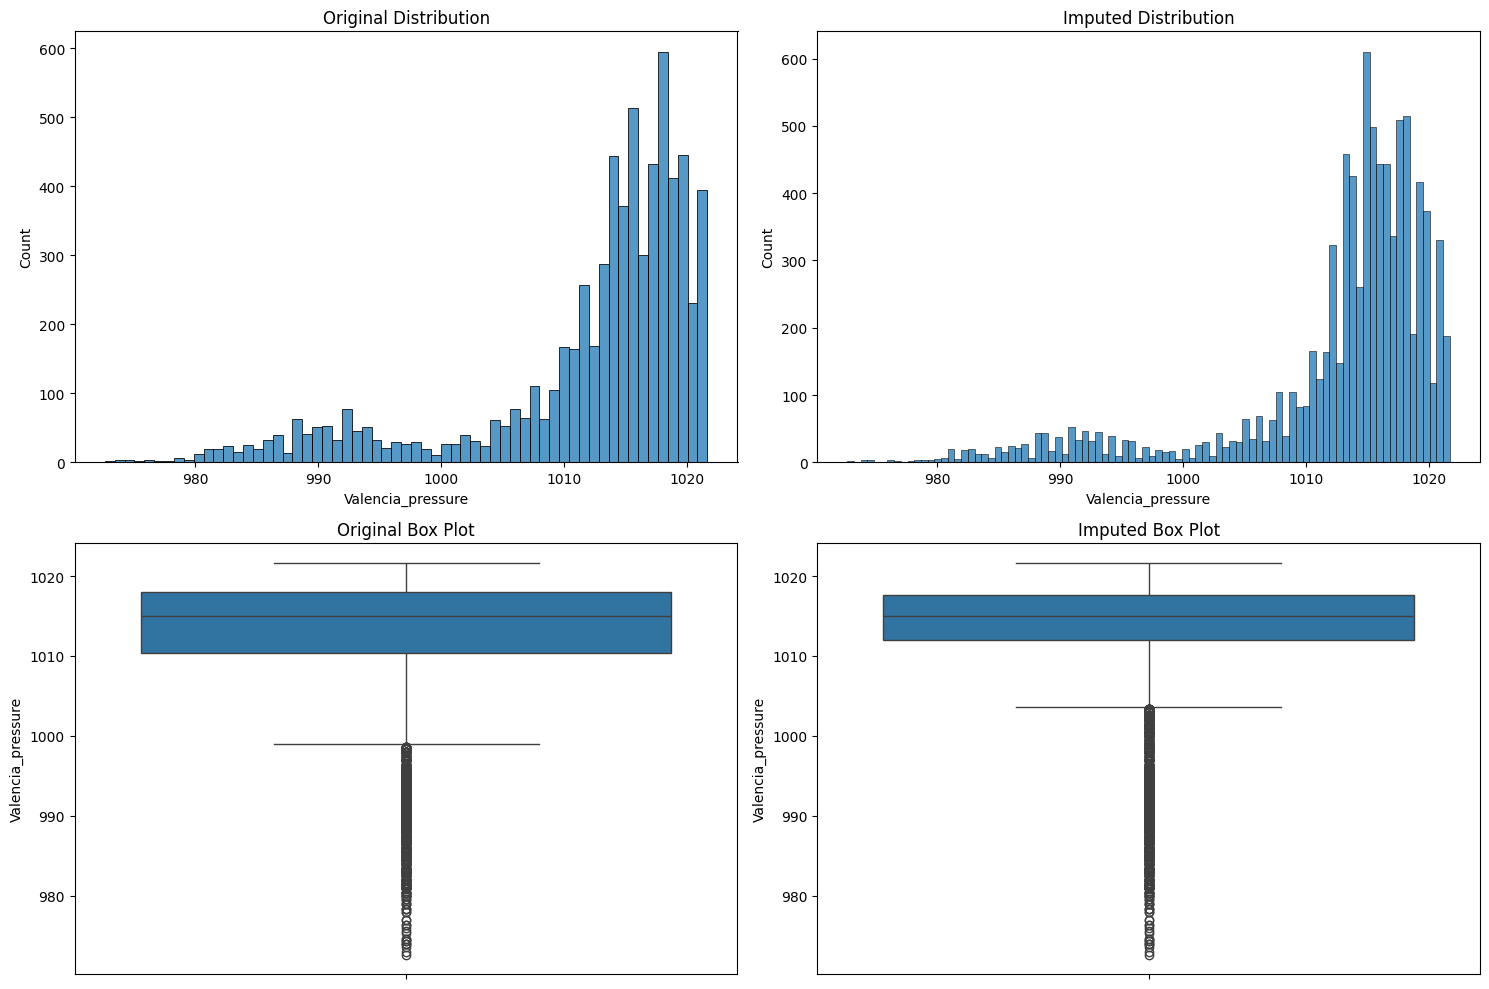


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 2068.00
missing_percentage: 23.59
mean: 1012.05
median: 1015.00
std: 9.51
min: 972.67
max: 1021.67

Imputed Data:
missing_count: 0.00
missing_percentage: 0.00
mean: 1012.71
median: 1015.00
std: 8.51
min: 972.67
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 0.66 (+0.07%)
median: 0.00 (+0.00%)
std: -1.00 (-10.53%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


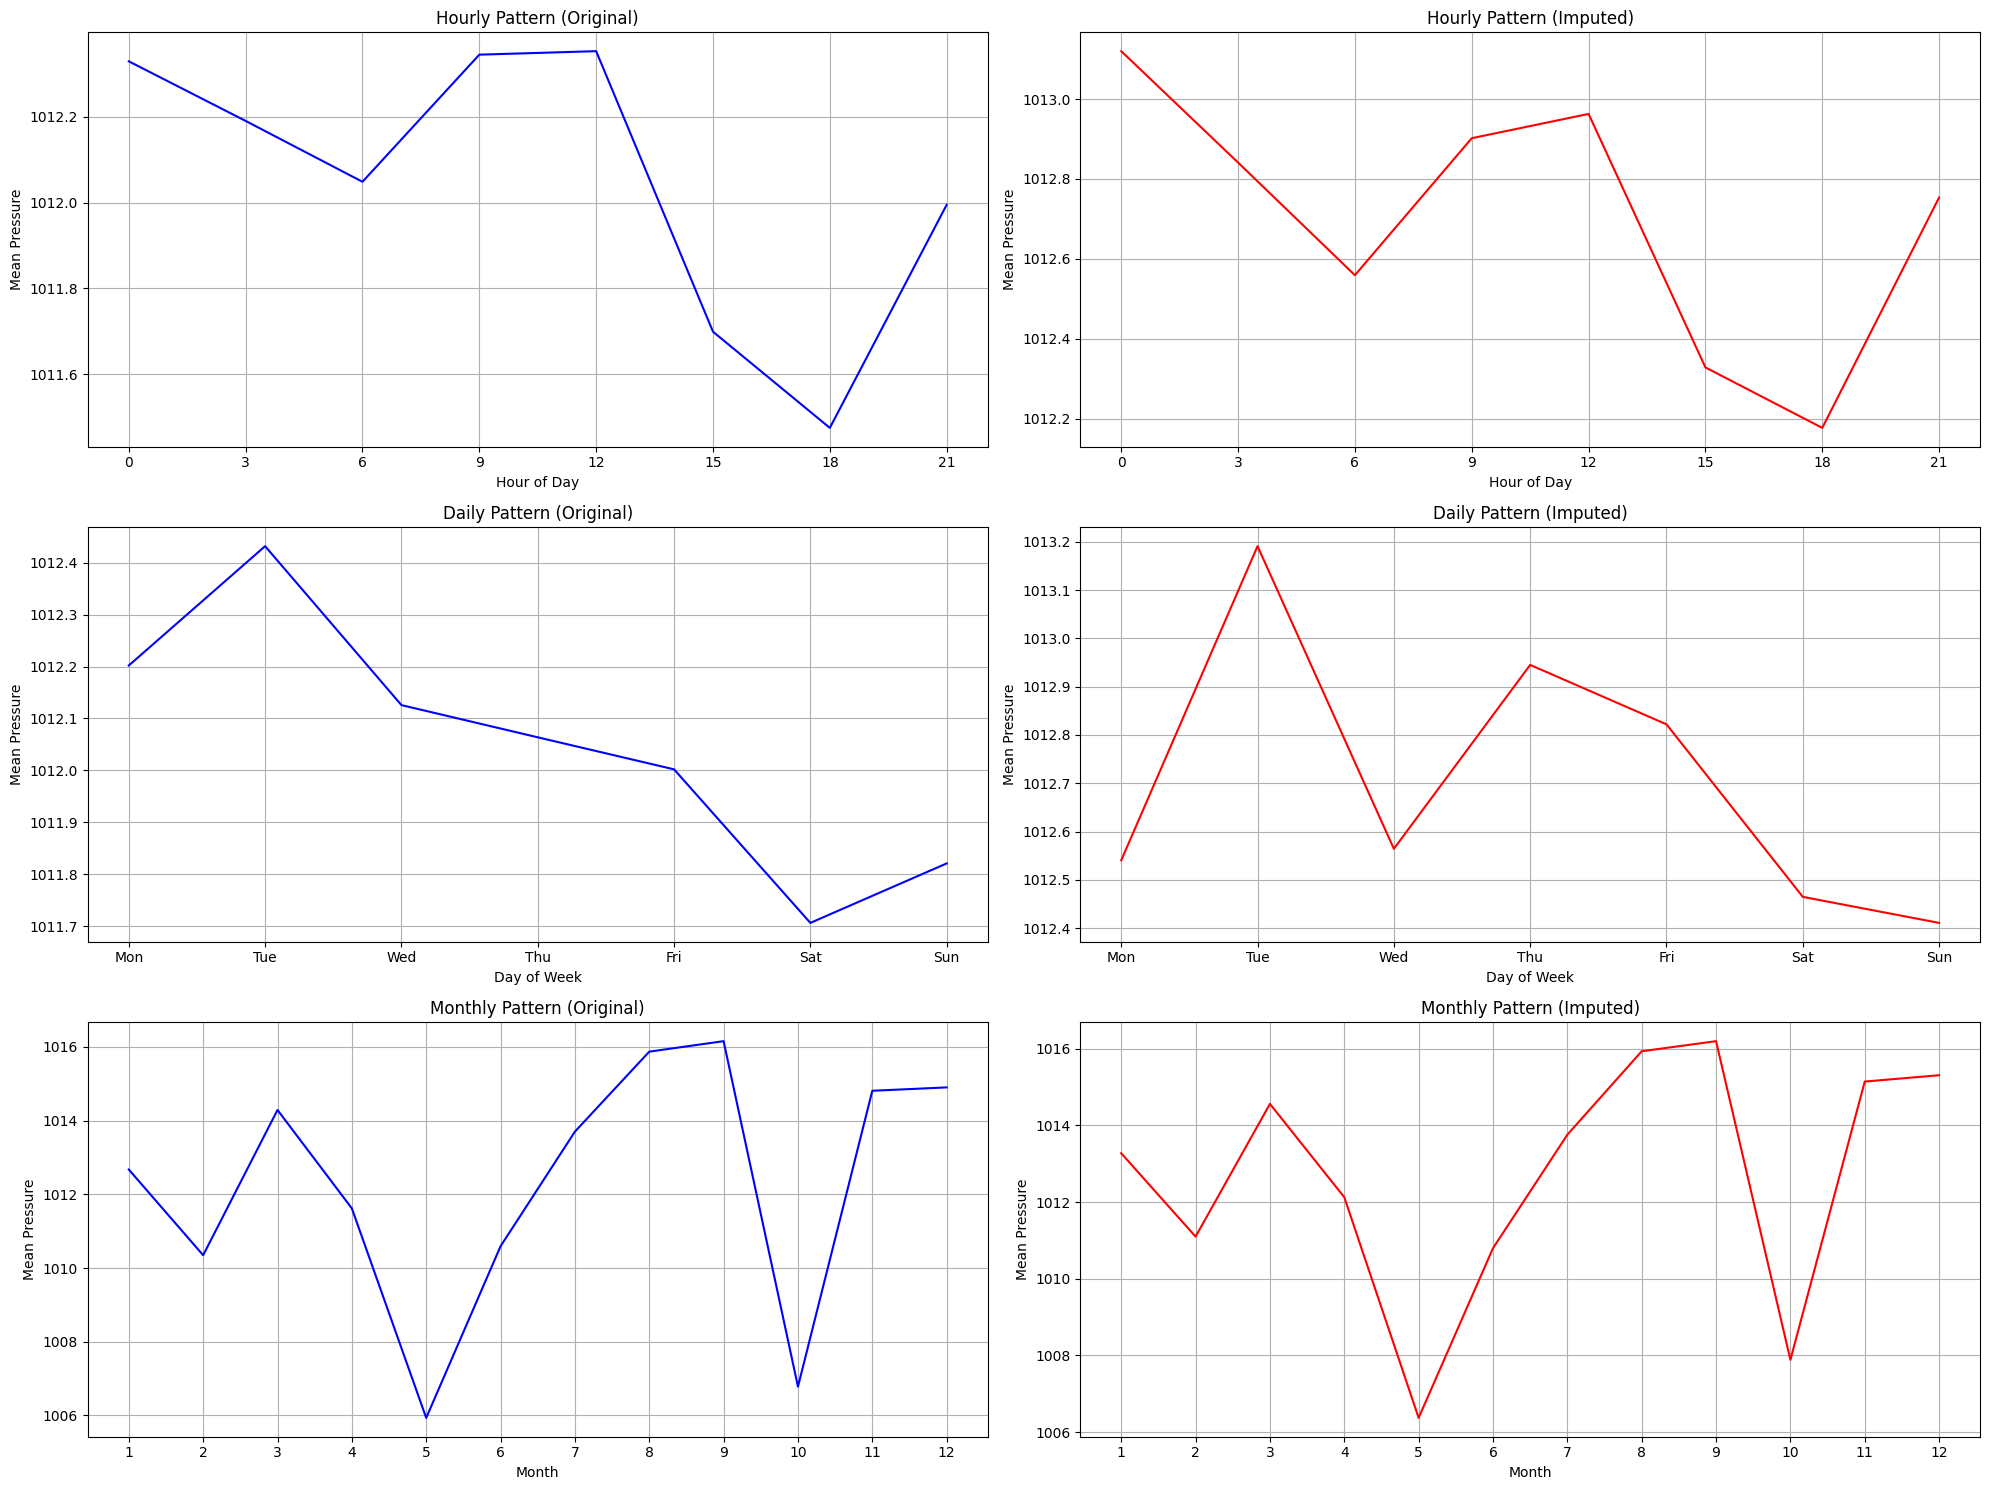


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 0.65
Maximum difference: 0.79

Daily Pattern Differences:
Mean absolute difference: 0.66
Maximum difference: 0.88

Monthly Pattern Differences:
Mean absolute difference: 0.40
Maximum difference: 1.10


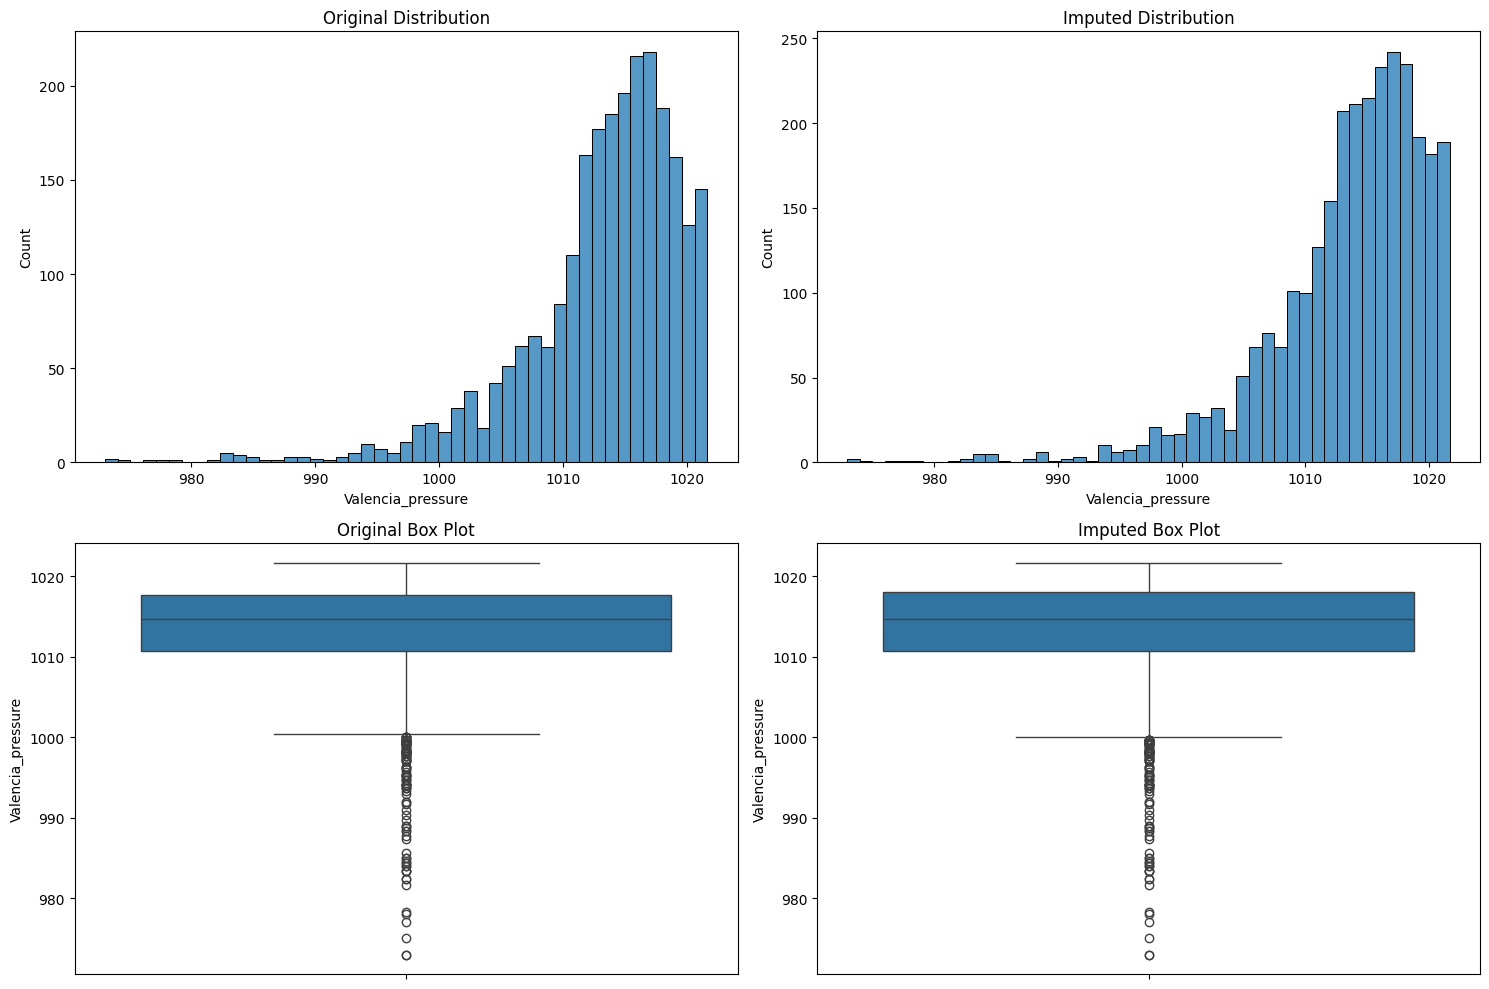


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 454.00
missing_percentage: 15.55
mean: 1013.15
median: 1014.67
std: 6.53
min: 973.00
max: 1021.67

Imputed Data:
missing_count: 40.00
missing_percentage: 1.37
mean: 1013.42
median: 1014.67
std: 6.36
min: 973.00
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 0.27 (+0.03%)
median: 0.00 (+0.00%)
std: -0.17 (-2.56%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


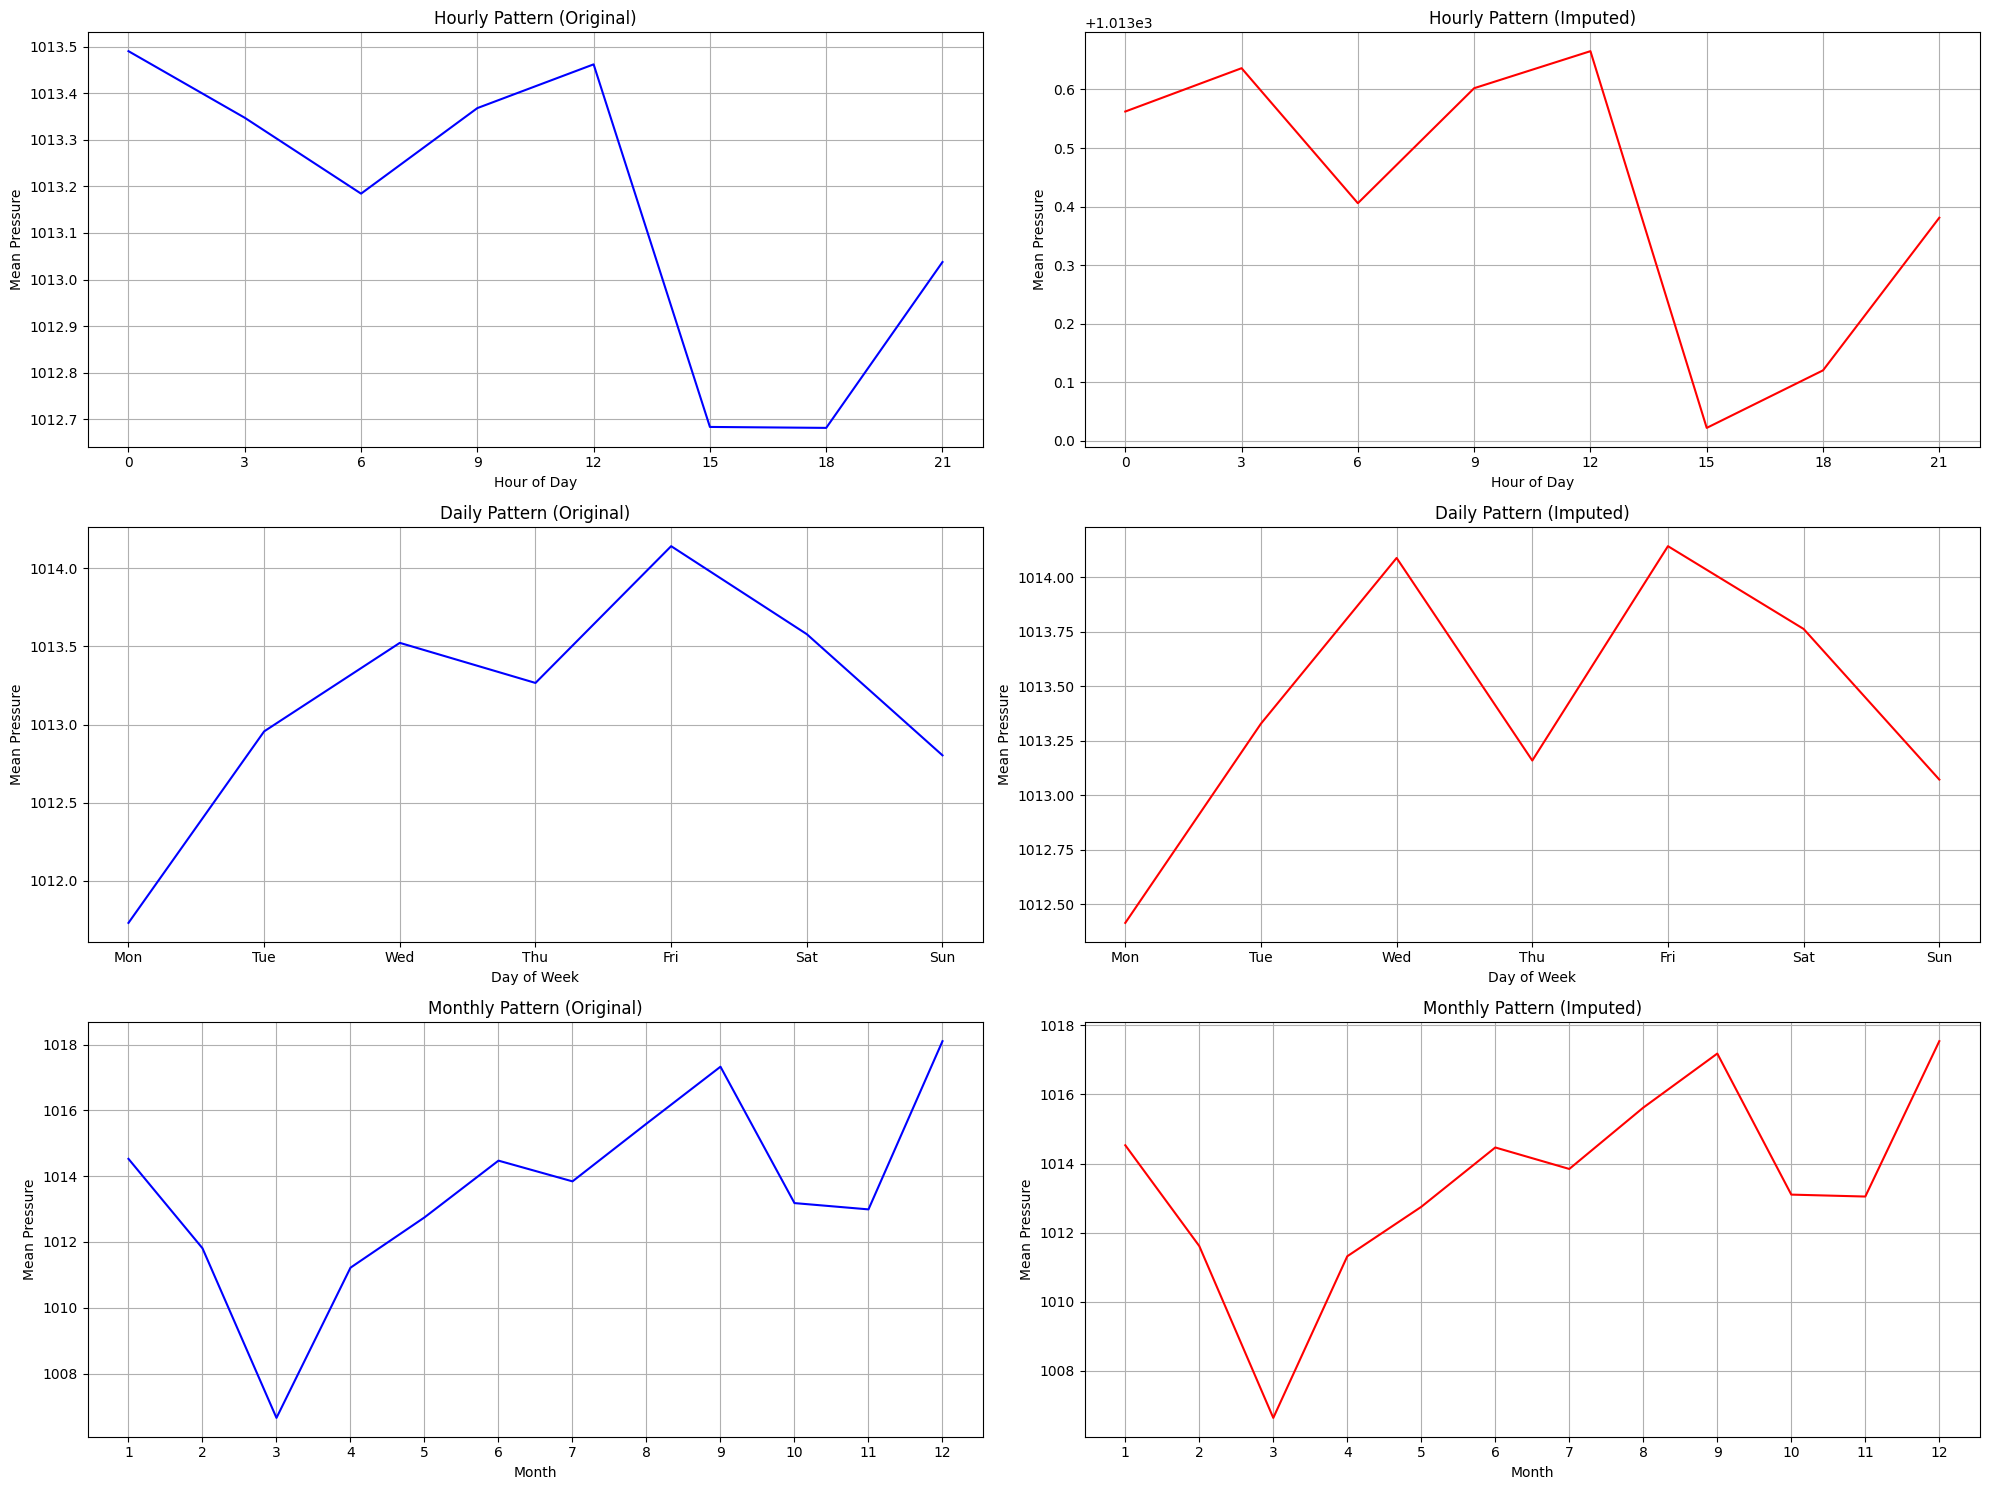


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 0.27
Maximum difference: 0.44

Daily Pattern Differences:
Mean absolute difference: 0.31
Maximum difference: 0.68

Monthly Pattern Differences:
Mean absolute difference: 0.10
Maximum difference: 0.56


In [13]:
from preprocessing import ValenciaPressureImputer, set_datetime_as_index
from sklearn.base import BaseEstimator, TransformerMixin

class ValenciaPressureImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = X.copy()
        df['hour'] = df.index.hour
        df['day'] = df.index.dayofweek
        df['month'] = df.index.month

        self.group_medians_ = df.groupby(['hour', 'day', 'month'])['Valencia_pressure'].median()
        return self

    def transform(self, X):
        df = X.copy()
        df['hour'] = df.index.hour
        df['day'] = df.index.dayofweek
        df['month'] = df.index.month

        def impute(row):
            if pd.isna(row['Valencia_pressure']):
                return self.group_medians_.get((row['hour'], row['day'], row['month']), np.nan)
            return row['Valencia_pressure']

        df['Valencia_pressure'] = df.apply(impute, axis=1)
        df.drop(['hour', 'day', 'month'], axis=1, inplace=True)
        return df

def analyze_valencia_pressure_imputation(df, imputer=ValenciaPressureImputer()):
    """
    Applies ValenciaPressureImputer and analyzes the changes in Valencia pressure distribution.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data
        
    Returns:
    --------
    tuple
        (original_df, imputed_df, imputation_stats)
    """
    # Create a copy of the original data
    original_df = df.copy()
    
    # Initialize and apply the imputer
    imputed_df = imputer.fit_transform(original_df)
    
    # Calculate statistics before and after imputation
    imputation_stats = {
        'original': {
            'missing_count': original_df['Valencia_pressure'].isna().sum(),
            'missing_percentage': (original_df['Valencia_pressure'].isna().sum() / len(original_df)) * 100,
            'mean': original_df['Valencia_pressure'].mean(),
            'median': original_df['Valencia_pressure'].median(),
            'std': original_df['Valencia_pressure'].std(),
            'min': original_df['Valencia_pressure'].min(),
            'max': original_df['Valencia_pressure'].max()
        },
        'imputed': {
            'missing_count': imputed_df['Valencia_pressure'].isna().sum(),
            'missing_percentage': (imputed_df['Valencia_pressure'].isna().sum() / len(imputed_df)) * 100,
            'mean': imputed_df['Valencia_pressure'].mean(),
            'median': imputed_df['Valencia_pressure'].median(),
            'std': imputed_df['Valencia_pressure'].std(),
            'min': imputed_df['Valencia_pressure'].min(),
            'max': imputed_df['Valencia_pressure'].max()
        }
    }
    
    # Create visualizations
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # Original distribution
    sns.histplot(data=original_df, x='Valencia_pressure', ax=ax1)
    ax1.set_title('Original Distribution')
    
    # Imputed distribution
    sns.histplot(data=imputed_df, x='Valencia_pressure', ax=ax2)
    ax2.set_title('Imputed Distribution')
    
    # Original box plot
    sns.boxplot(data=original_df, y='Valencia_pressure', ax=ax3)
    ax3.set_title('Original Box Plot')
    
    # Imputed box plot
    sns.boxplot(data=imputed_df, y='Valencia_pressure', ax=ax4)
    ax4.set_title('Imputed Box Plot')
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics
    print("\nImputation Statistics:")
    print("-" * 50)
    print("\nOriginal Data:")
    for stat, value in imputation_stats['original'].items():
        print(f"{stat}: {value:.2f}")
    
    print("\nImputed Data:")
    for stat, value in imputation_stats['imputed'].items():
        print(f"{stat}: {value:.2f}")
    
    # Calculate and print changes
    print("\nChanges after imputation:")
    print("-" * 50)
    for stat in imputation_stats['original'].keys():
        if stat not in ['missing_count', 'missing_percentage']:
            change = imputation_stats['imputed'][stat] - imputation_stats['original'][stat]
            change_percentage = (change / imputation_stats['original'][stat]) * 100
            print(f"{stat}: {change:.2f} ({change_percentage:+.2f}%)")
    
    return original_df, imputed_df, imputation_stats


def analyze_temporal_patterns(original_df, imputed_df):
    """
    Analyzes and visualizes temporal patterns in Valencia pressure before and after imputation.
    
    Parameters:
    -----------
    original_df : pandas.DataFrame
        The original DataFrame
    imputed_df : pandas.DataFrame
        The imputed DataFrame
    """
    # Create temporal features for both DataFrames
    for df in [original_df, imputed_df]:
        df['hour'] = df.index.hour
        df['day'] = df.index.dayofweek
        df['month'] = df.index.month
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Hourly patterns
    plt.subplot(3, 2, 1)
    original_hourly = original_df.groupby('hour')['Valencia_pressure'].mean()
    plt.plot(original_hourly.index, original_hourly.values, 'b-', label='Original')
    plt.title('Hourly Pattern (Original)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Mean Pressure')
    plt.xticks(range(0, 24, 3))
    plt.grid(True)
    
    plt.subplot(3, 2, 2)
    imputed_hourly = imputed_df.groupby('hour')['Valencia_pressure'].mean()
    plt.plot(imputed_hourly.index, imputed_hourly.values, 'r-', label='Imputed')
    plt.title('Hourly Pattern (Imputed)')
    plt.xlabel('Hour of Day')
    plt.ylabel('Mean Pressure')
    plt.xticks(range(0, 24, 3))
    plt.grid(True)
    
    # 2. Daily patterns
    plt.subplot(3, 2, 3)
    original_daily = original_df.groupby('day')['Valencia_pressure'].mean()
    plt.plot(original_daily.index, original_daily.values, 'b-', label='Original')
    plt.title('Daily Pattern (Original)')
    plt.xlabel('Day of Week')
    plt.ylabel('Mean Pressure')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True)
    
    plt.subplot(3, 2, 4)
    imputed_daily = imputed_df.groupby('day')['Valencia_pressure'].mean()
    plt.plot(imputed_daily.index, imputed_daily.values, 'r-', label='Imputed')
    plt.title('Daily Pattern (Imputed)')
    plt.xlabel('Day of Week')
    plt.ylabel('Mean Pressure')
    plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
    plt.grid(True)
    
    # 3. Monthly patterns
    plt.subplot(3, 2, 5)
    original_monthly = original_df.groupby('month')['Valencia_pressure'].mean()
    plt.plot(original_monthly.index, original_monthly.values, 'b-', label='Original')
    plt.title('Monthly Pattern (Original)')
    plt.xlabel('Month')
    plt.ylabel('Mean Pressure')
    plt.xticks(range(1, 13))
    plt.grid(True)
    
    plt.subplot(3, 2, 6)
    imputed_monthly = imputed_df.groupby('month')['Valencia_pressure'].mean()
    plt.plot(imputed_monthly.index, imputed_monthly.values, 'r-', label='Imputed')
    plt.title('Monthly Pattern (Imputed)')
    plt.xlabel('Month')
    plt.ylabel('Mean Pressure')
    plt.xticks(range(1, 13))
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Calculate and print statistics for temporal patterns
    print("\nTemporal Pattern Statistics:")
    print("-" * 50)
    
    # Hourly statistics
    print("\nHourly Pattern Differences:")
    hourly_diff = imputed_hourly - original_hourly
    print(f"Mean absolute difference: {hourly_diff.abs().mean():.2f}")
    print(f"Maximum difference: {hourly_diff.abs().max():.2f}")
    
    # Daily statistics
    print("\nDaily Pattern Differences:")
    daily_diff = imputed_daily - original_daily
    print(f"Mean absolute difference: {daily_diff.abs().mean():.2f}")
    print(f"Maximum difference: {daily_diff.abs().max():.2f}")
    
    # Monthly statistics
    print("\nMonthly Pattern Differences:")
    monthly_diff = imputed_monthly - original_monthly
    print(f"Mean absolute difference: {monthly_diff.abs().mean():.2f}")
    print(f"Maximum difference: {monthly_diff.abs().max():.2f}")
    
    # Clean up temporary columns
    for df in [original_df, imputed_df]:
        df.drop(['hour', 'day', 'month'], axis=1, inplace=True)

def analyze_valencia_pressure_imputation_with_temporal(df, imputer=ValenciaPressureImputer()):
    """
    Combines the original imputation analysis with temporal pattern analysis.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        The DataFrame containing the data
    """
    # Run original analysis
    original_df, imputed_df, stats = analyze_valencia_pressure_imputation(df, imputer=imputer)
    
    # Add temporal pattern analysis
    print("\nAnalyzing Temporal Patterns...")
    analyze_temporal_patterns(original_df, imputed_df)
    
    return original_df, imputed_df, stats

copy_train_df = set_datetime_as_index(copy_train_df, freq='3h', fill_method='interpolate')
copy_test_df = set_datetime_as_index(copy_test_df, freq='3h', fill_method='interpolate')

original_df, imputed_df, stats = analyze_valencia_pressure_imputation_with_temporal(copy_train_df)
original_df, imputed_df, stats = analyze_valencia_pressure_imputation_with_temporal(copy_test_df)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin




from sklearn.impute import KNNImputer


# 1. Time-based Method: Interpolation with Fallback
class InterpolationImputer(BaseEstimator, TransformerMixin):
    def __init__(self, max_gap=24):
        """
        Time-based interpolation with fallback to pattern-based imputation
        
        Parameters:
        max_gap (int): Maximum gap size (in hours) to interpolate across
        """
        self.max_gap = max_gap
    
    def fit(self, X, y=None):
        # For fallback pattern-based imputation
        df = X.copy()
        df['hour'] = df.index.hour
        df['day'] = df.index.dayofweek
        
        # Using just hour and day of week for more robust patterns
        self.hourly_pattern_ = df.groupby('hour')['Valencia_pressure'].median()
        self.daily_pattern_ = df.groupby('day')['Valencia_pressure'].median()
        
        # Store global median as last resort
        self.global_median_ = df['Valencia_pressure'].median()
        
        return self
    
    def transform(self, X):
        df = X.copy()
        
        # First identify missing value locations
        missing_mask = df['Valencia_pressure'].isna()
        
        if missing_mask.sum() > 0:
            # Sort index to ensure time ordering
            df = df.sort_index()
            
            # Copy original series for reference
            original_series = df['Valencia_pressure'].copy()
            
            # Step 1: Perform interpolation for gaps smaller than max_gap
            # Create a helper series to identify gap sizes
            gap_helper = pd.Series(index=df.index, data=np.arange(len(df)))
            gap_helper[~missing_mask] = np.nan
            gap_helper = gap_helper.fillna(method='bfill')
            
            # Identify consecutive stretches of missing values
            stretches = gap_helper.dropna().diff().dropna()
            small_gaps = stretches[stretches <= self.max_gap].index
            
            # Perform interpolation only on small gaps
            if len(small_gaps) > 0:
                df_interp = df.copy()
                df_interp['Valencia_pressure'] = df_interp['Valencia_pressure'].interpolate(
                    method='time', limit_area='inside')
                
                # Apply interpolated values only to small gaps
                for idx in small_gaps:
                    start_idx = df.index.get_loc(idx) - int(stretches[idx])
                    end_idx = df.index.get_loc(idx) + 1
                    mask = slice(start_idx, end_idx)
                    df.loc[df.index[mask], 'Valencia_pressure'] = df_interp.loc[df.index[mask], 'Valencia_pressure']
            
            # Step 2: Fall back to pattern-based imputation for remaining NaNs
            still_missing = df['Valencia_pressure'].isna()
            
            if still_missing.sum() > 0:
                df['hour'] = df.index.hour
                df['day'] = df.index.dayofweek
                
                # Apply hour-of-day pattern
                for idx in df[still_missing].index:
                    hour = idx.hour
                    day = idx.dayofweek
                    
                    if hour in self.hourly_pattern_:
                        df.loc[idx, 'Valencia_pressure'] = self.hourly_pattern_[hour]
                    elif day in self.daily_pattern_:
                        df.loc[idx, 'Valencia_pressure'] = self.daily_pattern_[day]
                    else:
                        df.loc[idx, 'Valencia_pressure'] = self.global_median_
                
                df.drop(['hour', 'day'], axis=1, inplace=True)
        
        return df


# 2. ML-based Method: KNN Imputation with Time Features
class TimeAwareKNNImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_neighbors=5):
        """
        KNN-based imputation that incorporates time features
        
        Parameters:
        n_neighbors (int): Number of neighbors to use for KNN imputation
        """
        self.n_neighbors = n_neighbors
        self.imputer = KNNImputer(n_neighbors=n_neighbors)
    
    def fit(self, X, y=None):
        # No need to fit anything here as KNN imputation is lazy
        return self
    
    def transform(self, X):
        df = X.copy()
        
        # Create time-based features to help with imputation
        df['hour_sin'] = np.sin(2 * np.pi * df.index.hour / 24)
        df['hour_cos'] = np.cos(2 * np.pi * df.index.hour / 24)
        df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
        df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)
        df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
        df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
        
        # Extract any other columns that might be useful for imputation
        # Here we'll assume there might be temperature or other weather features
        feature_cols = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
                      'month_sin', 'month_cos', 'Valencia_pressure']
        
        # Add any other available columns that might correlate with pressure
        # Like temperature, humidity, etc.
        for col in df.columns:
            if col not in feature_cols and col != 'Valencia_pressure':
                if df[col].dtype in [np.float64, np.int64]:
                    feature_cols.append(col)
        
        # Apply KNN imputation
        imputed_data = self.imputer.fit_transform(df[feature_cols])
        
        # Put imputed pressure back
        df['Valencia_pressure'] = imputed_data[:, feature_cols.index('Valencia_pressure')]
        
        # Drop the added time features
        df.drop(['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
                'month_sin', 'month_cos'], axis=1, inplace=True)
        
        return df


# 3. Simplified Grouping Method: Hour and Day of Week
class SimplifiedPatternImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        df = X.copy()
        df['hour'] = df.index.hour
        df['day'] = df.index.dayofweek
        
        # Create different levels of patterns from most specific to most general
        self.hour_day_medians_ = df.groupby(['hour', 'day'])['Valencia_pressure'].median()
        self.hour_medians_ = df.groupby(['hour'])['Valencia_pressure'].median()
        self.day_medians_ = df.groupby(['day'])['Valencia_pressure'].median()
        self.global_median_ = df['Valencia_pressure'].median()
        
        return self
    
    def transform(self, X):
        df = X.copy()
        df['hour'] = df.index.hour
        df['day'] = df.index.dayofweek
        
        def impute(row):
            if pd.isna(row['Valencia_pressure']):
                # Try most specific pattern first
                pressure = self.hour_day_medians_.get((row['hour'], row['day']), np.nan)
                
                # Fall back to hour pattern
                if pd.isna(pressure):
                    pressure = self.hour_medians_.get(row['hour'], np.nan)
                
                # Fall back to day pattern
                if pd.isna(pressure):
                    pressure = self.day_medians_.get(row['day'], np.nan)
                    
                # Last resort: global median
                if pd.isna(pressure):
                    pressure = self.global_median_
                
                return pressure
            return row['Valencia_pressure']
        
        df['Valencia_pressure'] = df.apply(impute, axis=1)
        df.drop(['hour', 'day'], axis=1, inplace=True)
        
        return df



Training Stats with InterpolationImputer


C:\Users\lackerman008\AppData\Local\Temp\ipykernel_2376\1120741775.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gap_helper = gap_helper.fillna(method='bfill')


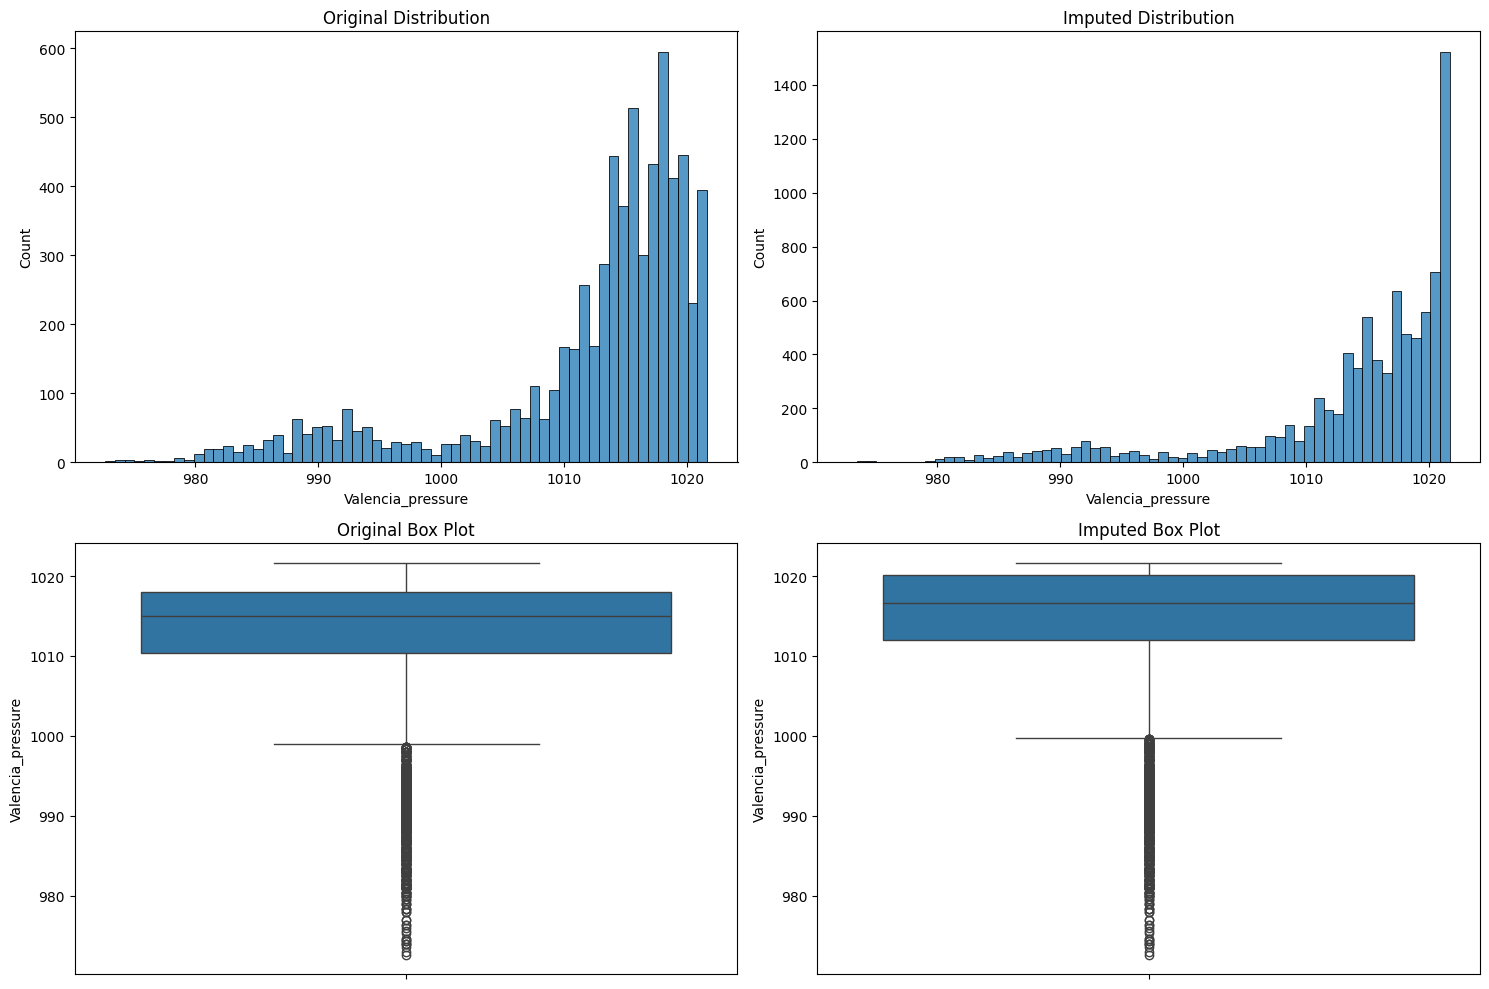


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 2068.00
missing_percentage: 23.59
mean: 1012.05
median: 1015.00
std: 9.51
min: 972.67
max: 1021.67

Imputed Data:
missing_count: 0.00
missing_percentage: 0.00
mean: 1013.80
median: 1016.67
std: 9.17
min: 972.67
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 1.75 (+0.17%)
median: 1.67 (+0.16%)
std: -0.33 (-3.52%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


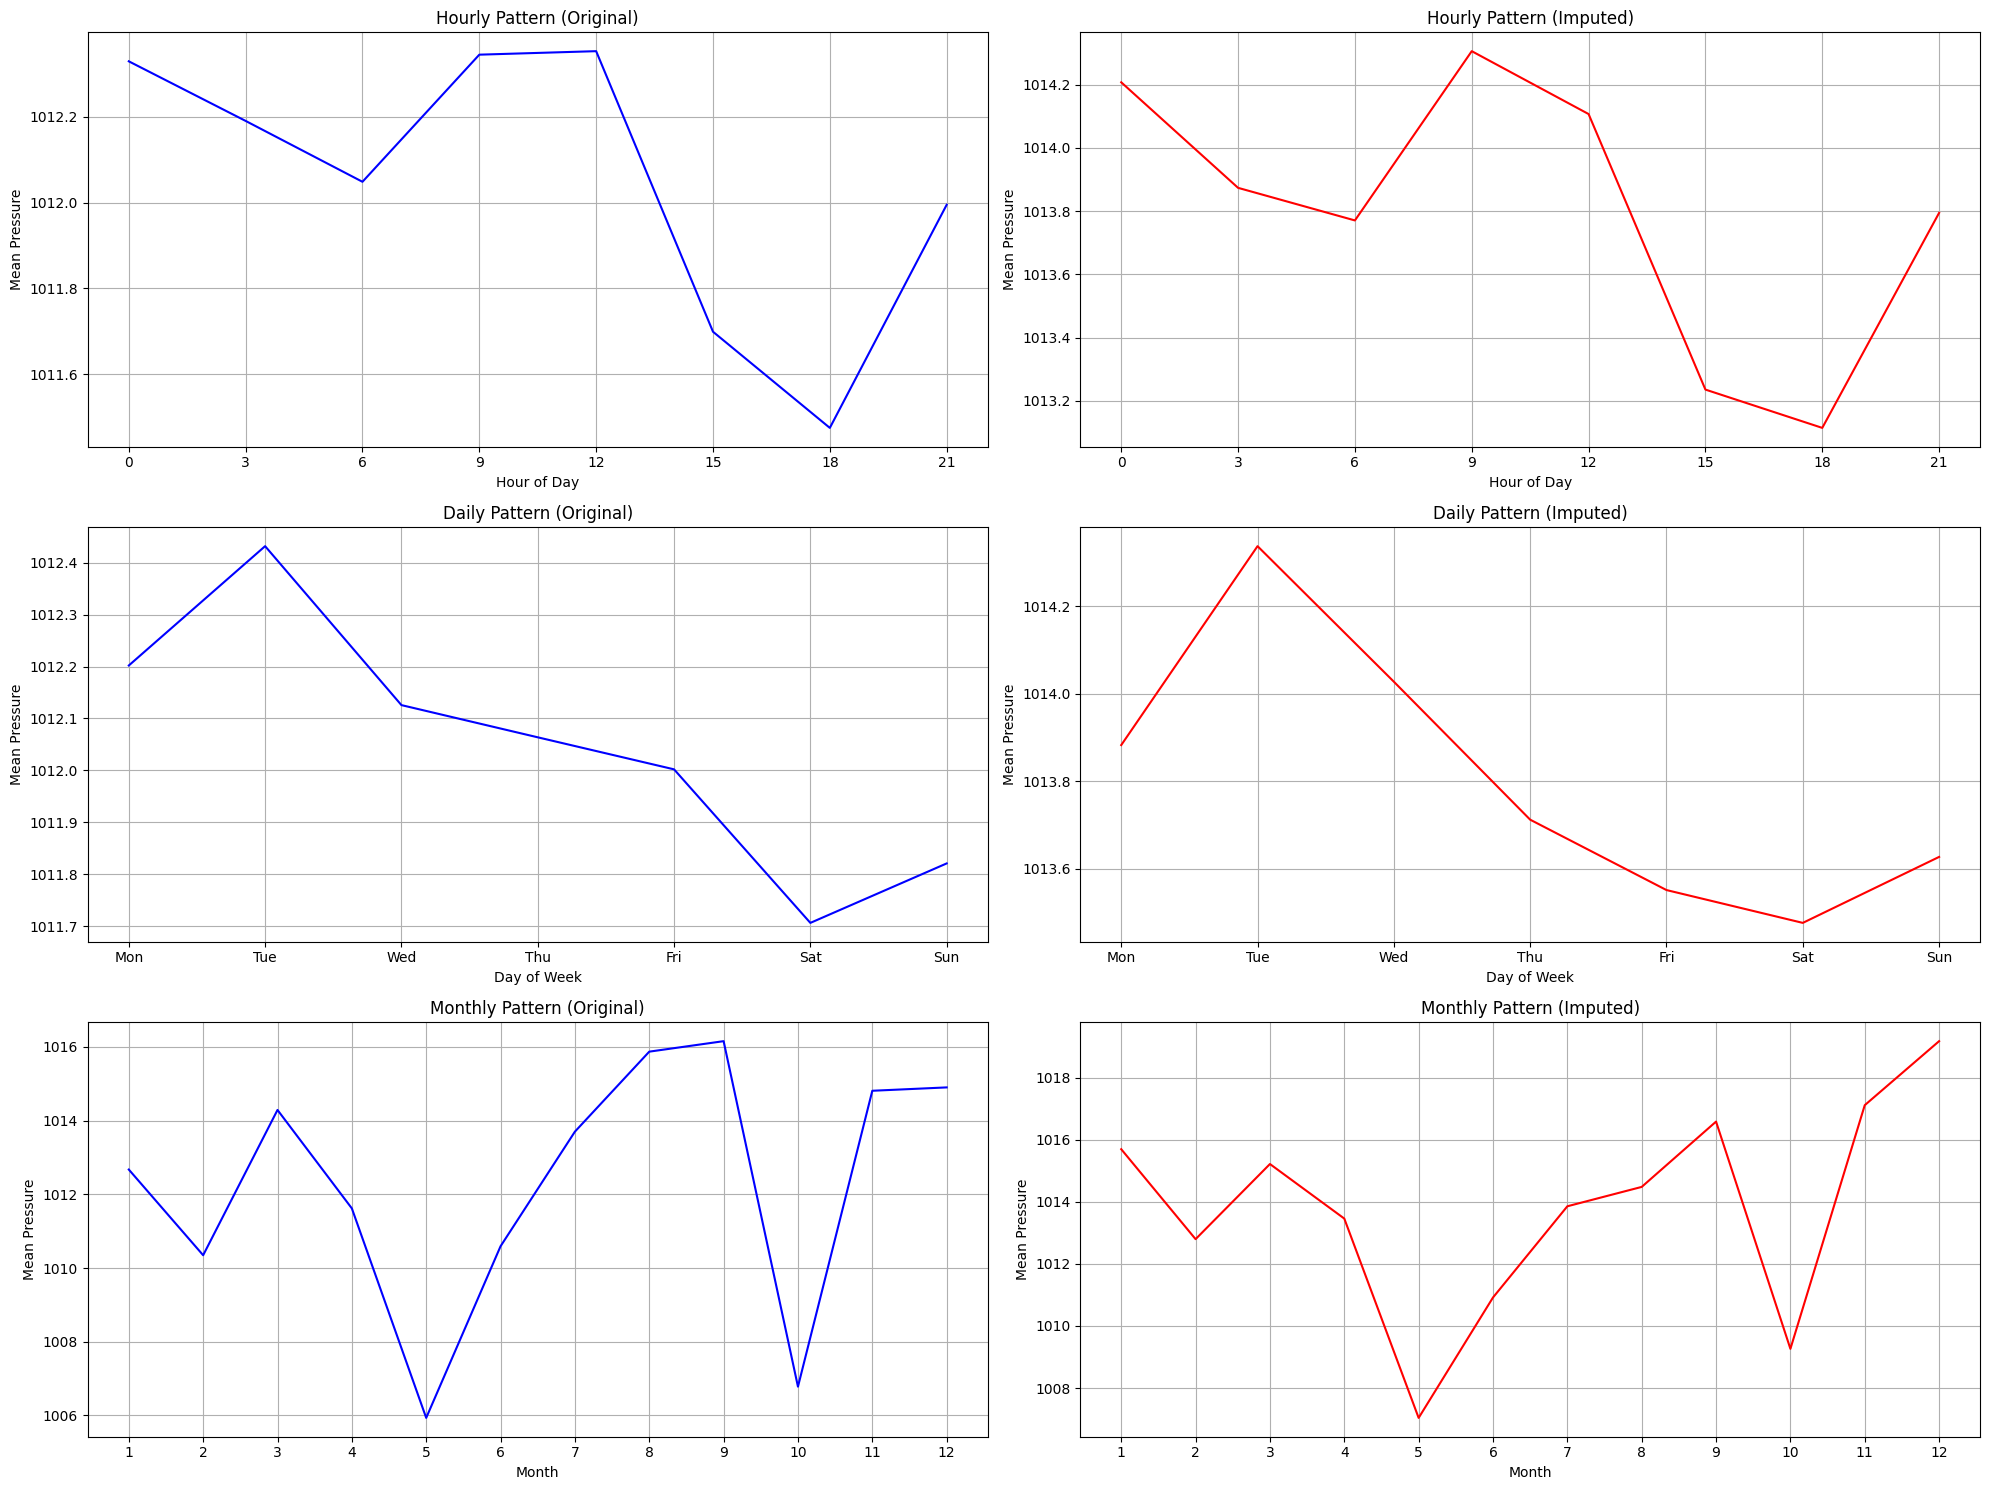


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 1.75
Maximum difference: 1.96

Daily Pattern Differences:
Mean absolute difference: 1.75
Maximum difference: 1.90

Monthly Pattern Differences:
Mean absolute difference: 1.73
Maximum difference: 4.28


C:\Users\lackerman008\AppData\Local\Temp\ipykernel_2376\1120741775.py:48: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gap_helper = gap_helper.fillna(method='bfill')


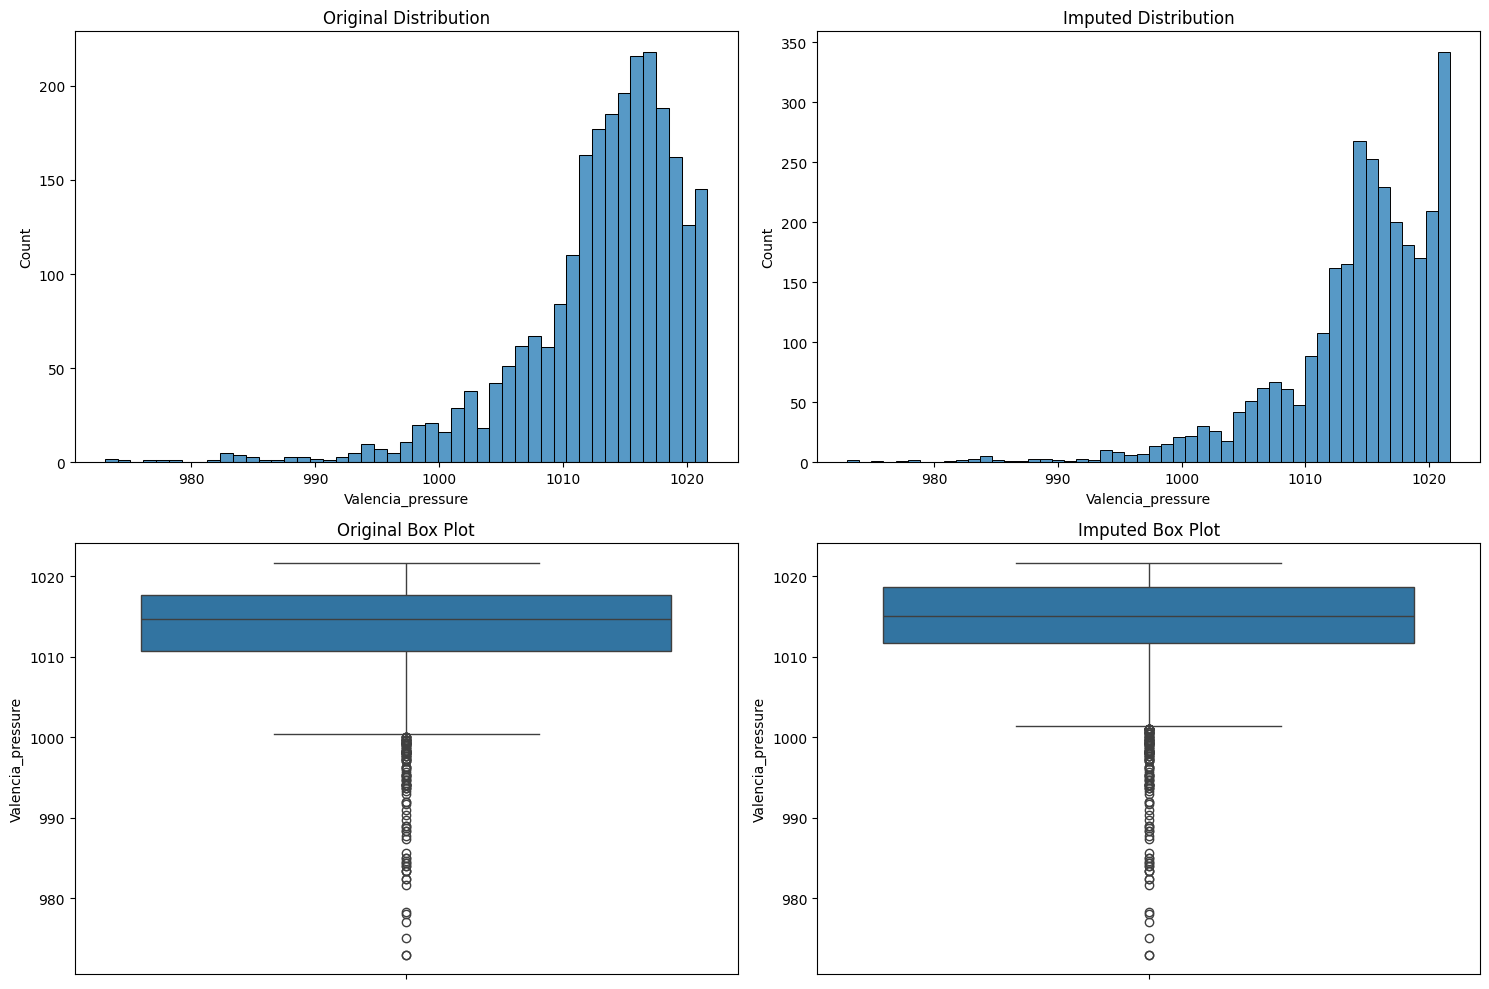


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 454.00
missing_percentage: 15.55
mean: 1013.15
median: 1014.67
std: 6.53
min: 973.00
max: 1021.67

Imputed Data:
missing_count: 0.00
missing_percentage: 0.00
mean: 1014.07
median: 1015.00
std: 6.47
min: 973.00
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 0.92 (+0.09%)
median: 0.33 (+0.03%)
std: -0.06 (-0.87%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


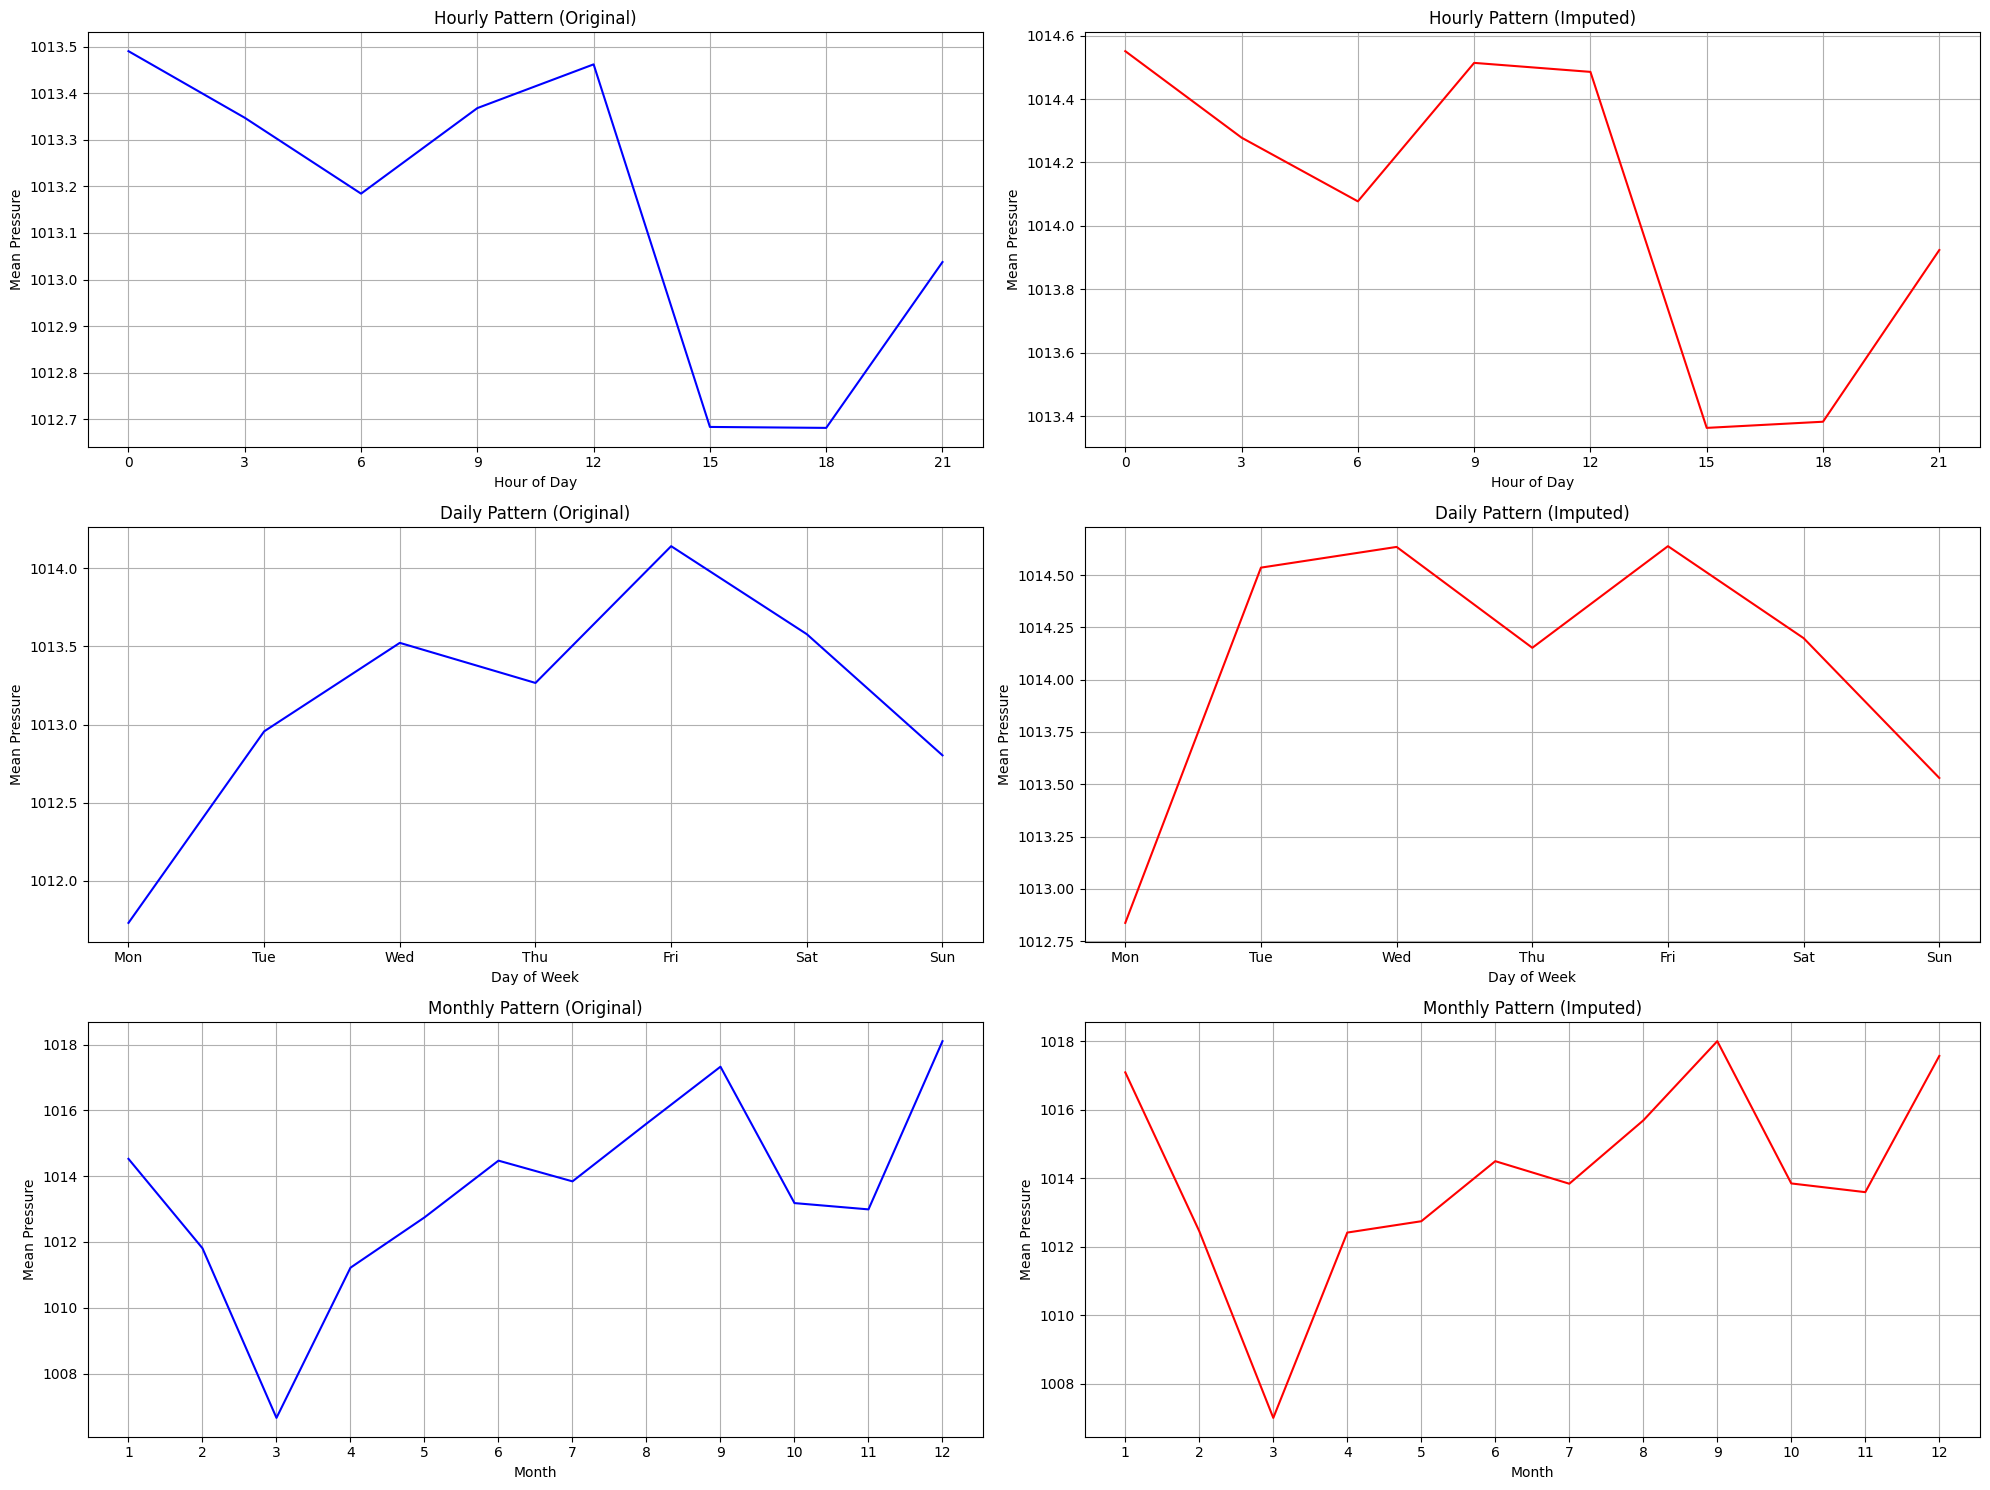


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 0.92
Maximum difference: 1.15

Daily Pattern Differences:
Mean absolute difference: 0.93
Maximum difference: 1.58

Monthly Pattern Differences:
Mean absolute difference: 0.61
Maximum difference: 2.57
Training Stats with TimeAwareKNNImputer


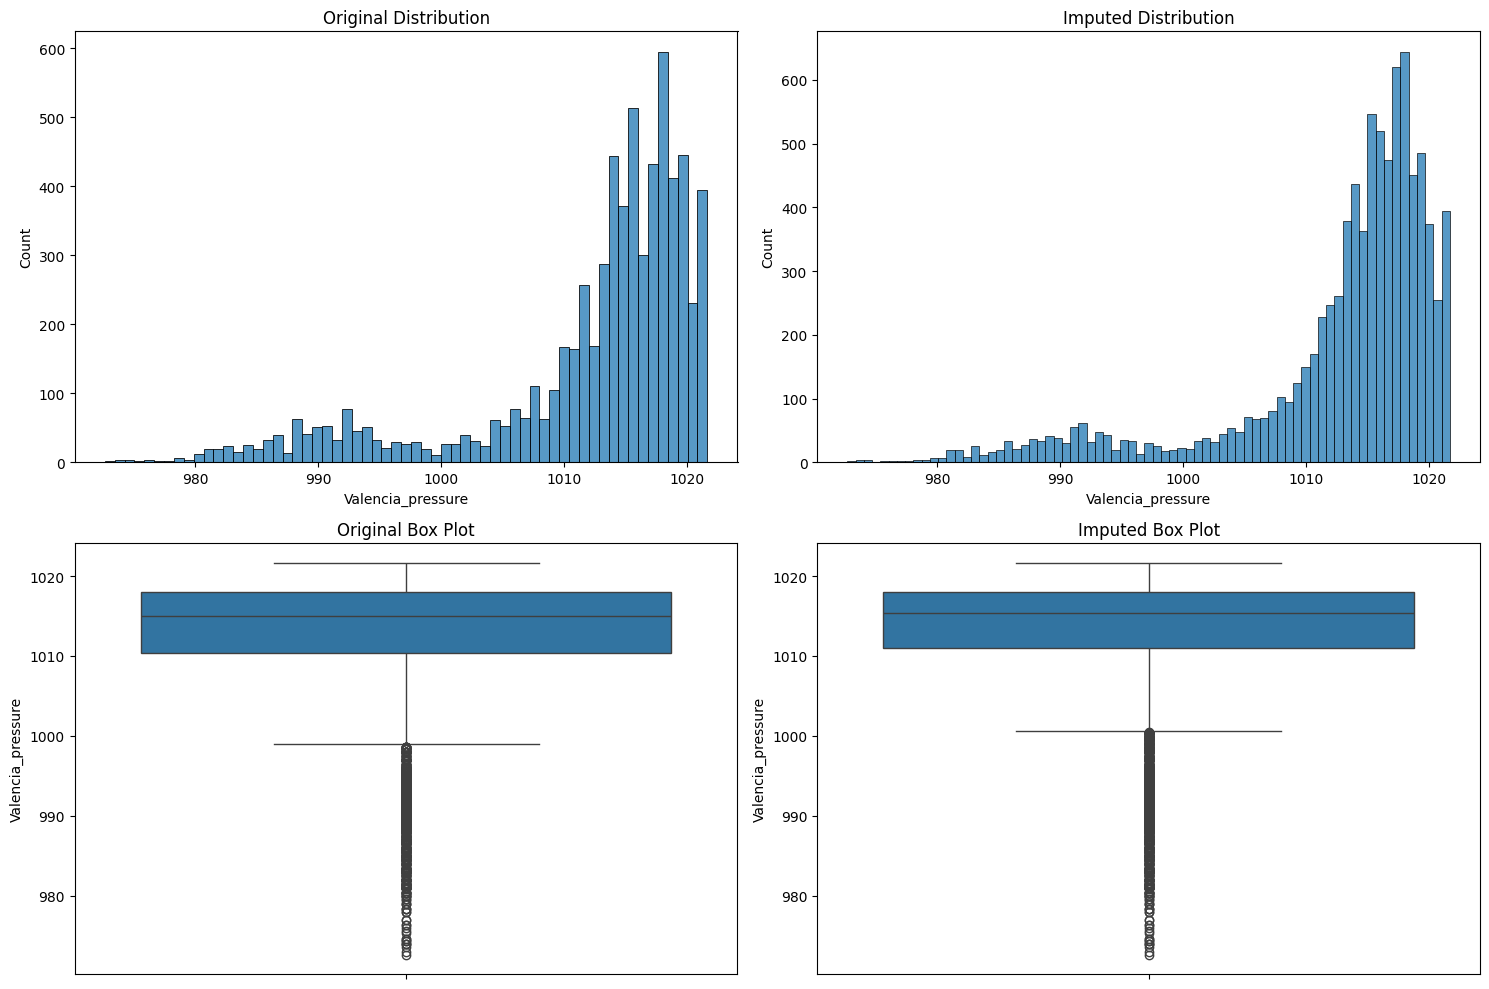


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 2068.00
missing_percentage: 23.59
mean: 1012.05
median: 1015.00
std: 9.51
min: 972.67
max: 1021.67

Imputed Data:
missing_count: 0.00
missing_percentage: 0.00
mean: 1012.61
median: 1015.33
std: 8.69
min: 972.67
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 0.56 (+0.06%)
median: 0.33 (+0.03%)
std: -0.82 (-8.63%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


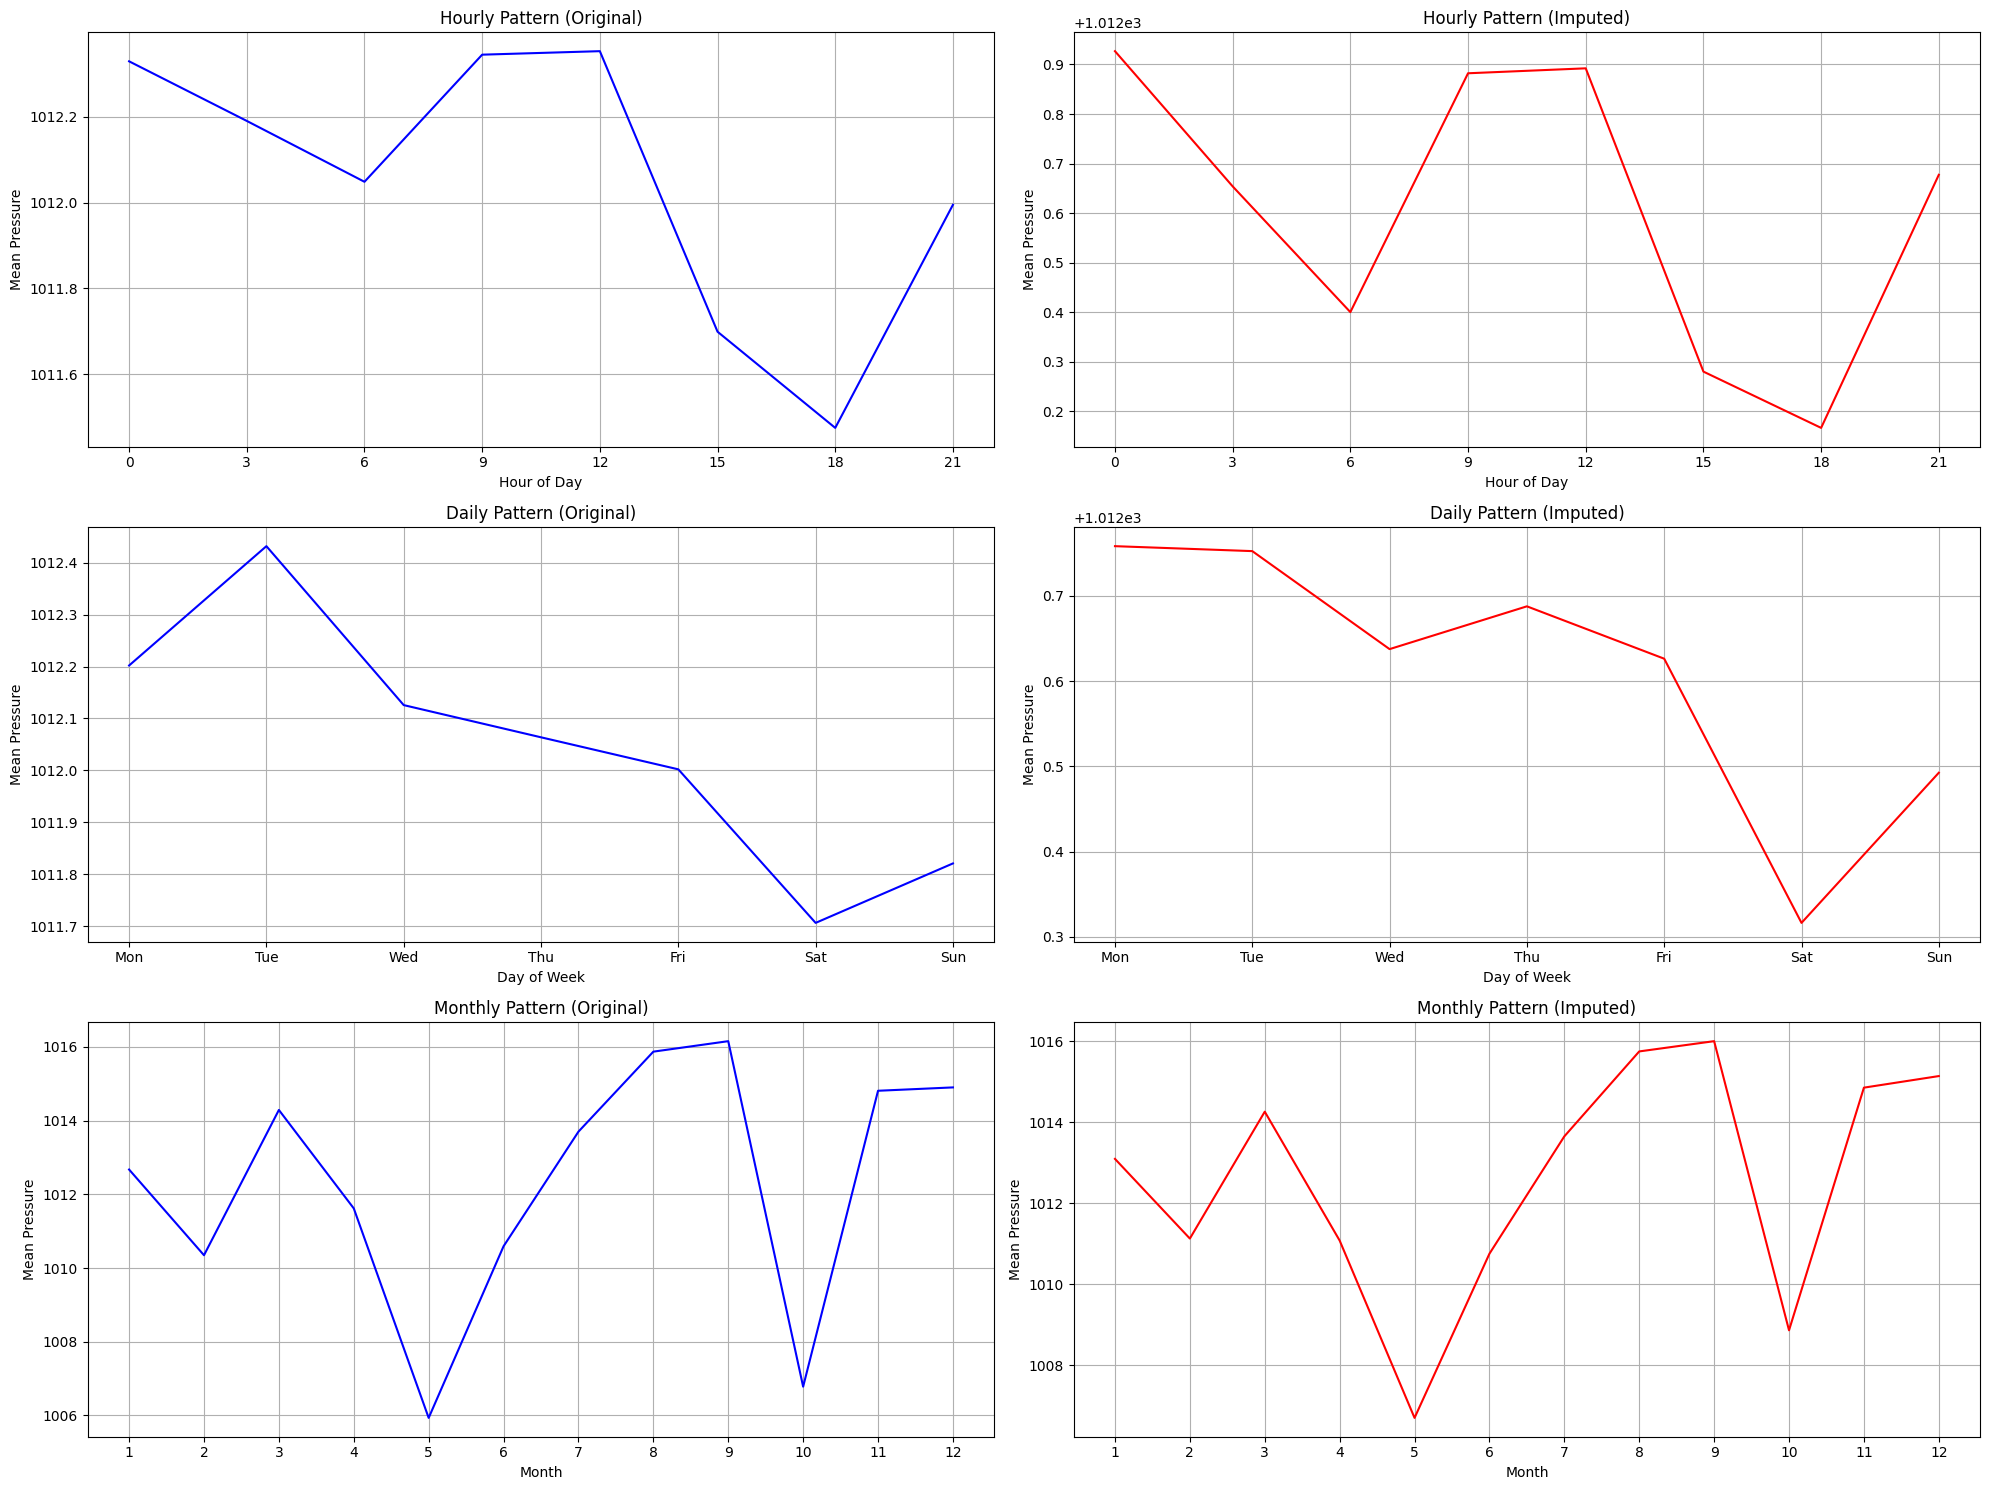


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 0.56
Maximum difference: 0.69

Daily Pattern Differences:
Mean absolute difference: 0.56
Maximum difference: 0.67

Monthly Pattern Differences:
Mean absolute difference: 0.45
Maximum difference: 2.08


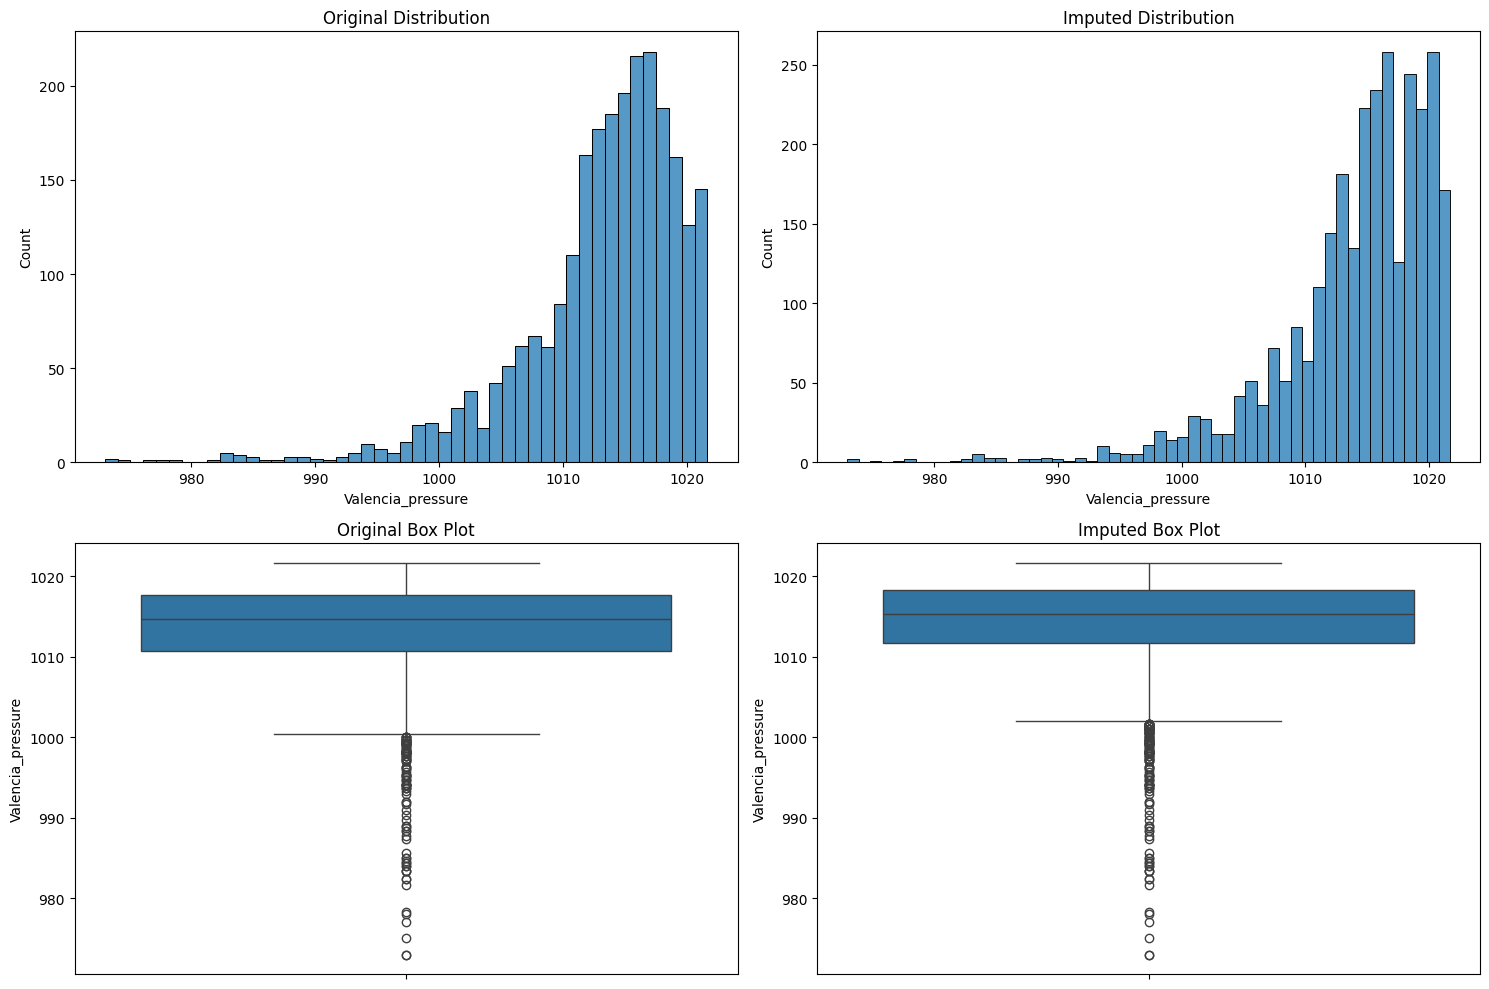


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 454.00
missing_percentage: 15.55
mean: 1013.15
median: 1014.67
std: 6.53
min: 973.00
max: 1021.67

Imputed Data:
missing_count: 0.00
missing_percentage: 0.00
mean: 1014.00
median: 1015.33
std: 6.40
min: 973.00
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 0.85 (+0.08%)
median: 0.67 (+0.07%)
std: -0.13 (-2.01%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


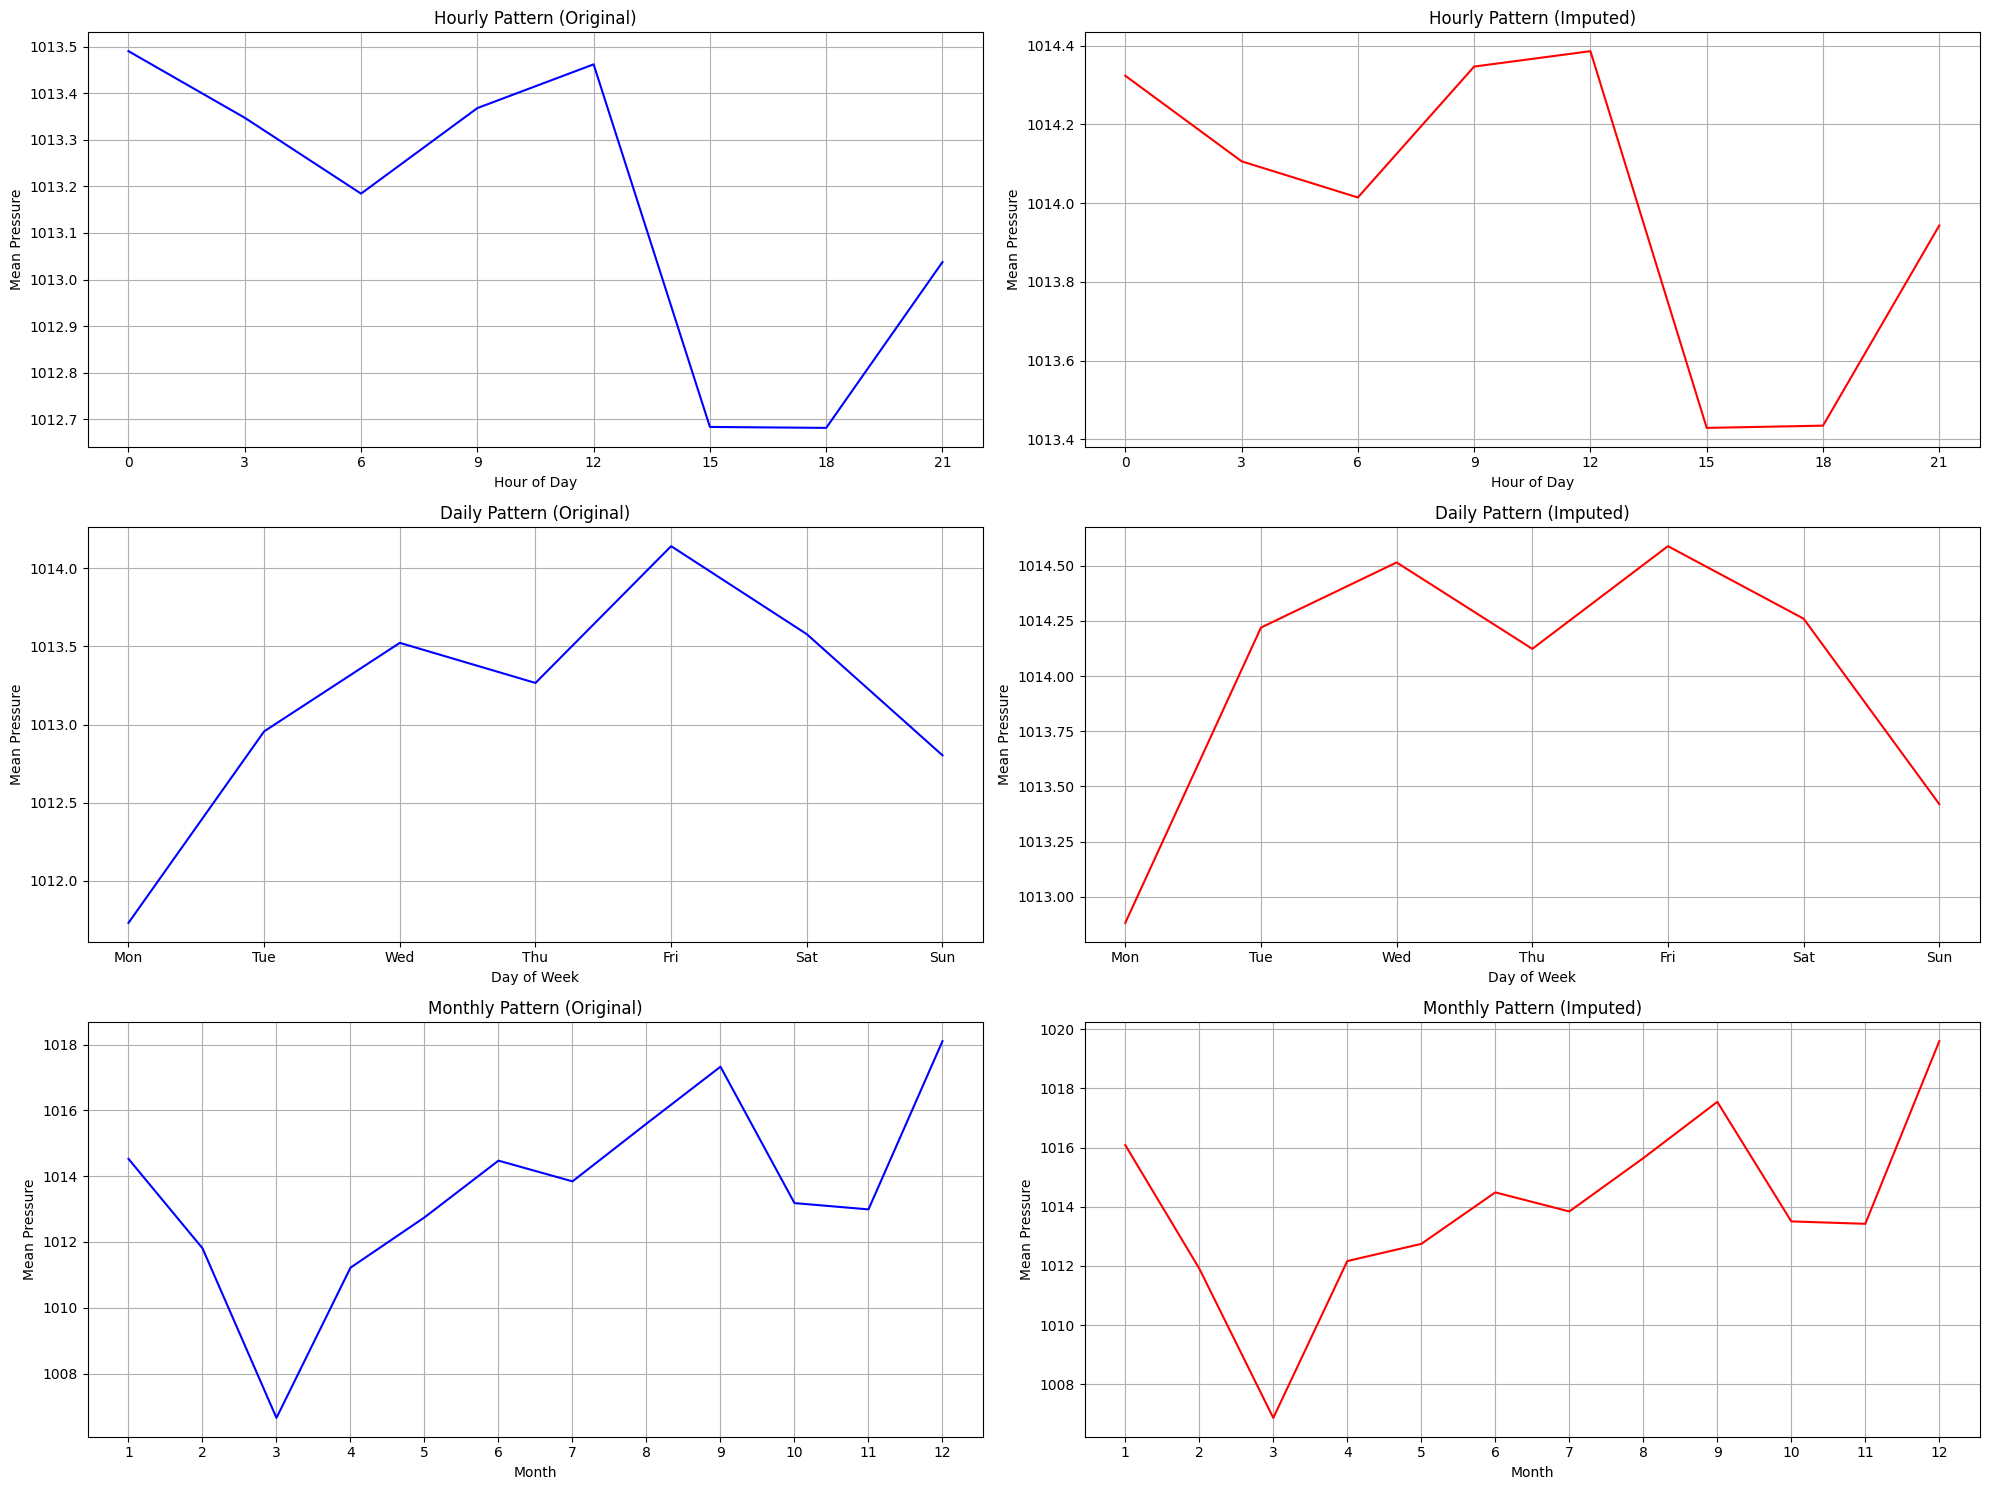


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 0.84
Maximum difference: 0.98

Daily Pattern Differences:
Mean absolute difference: 0.86
Maximum difference: 1.26

Monthly Pattern Differences:
Mean absolute difference: 0.45
Maximum difference: 1.56
Training Stats with SimplifiedPatternImputer


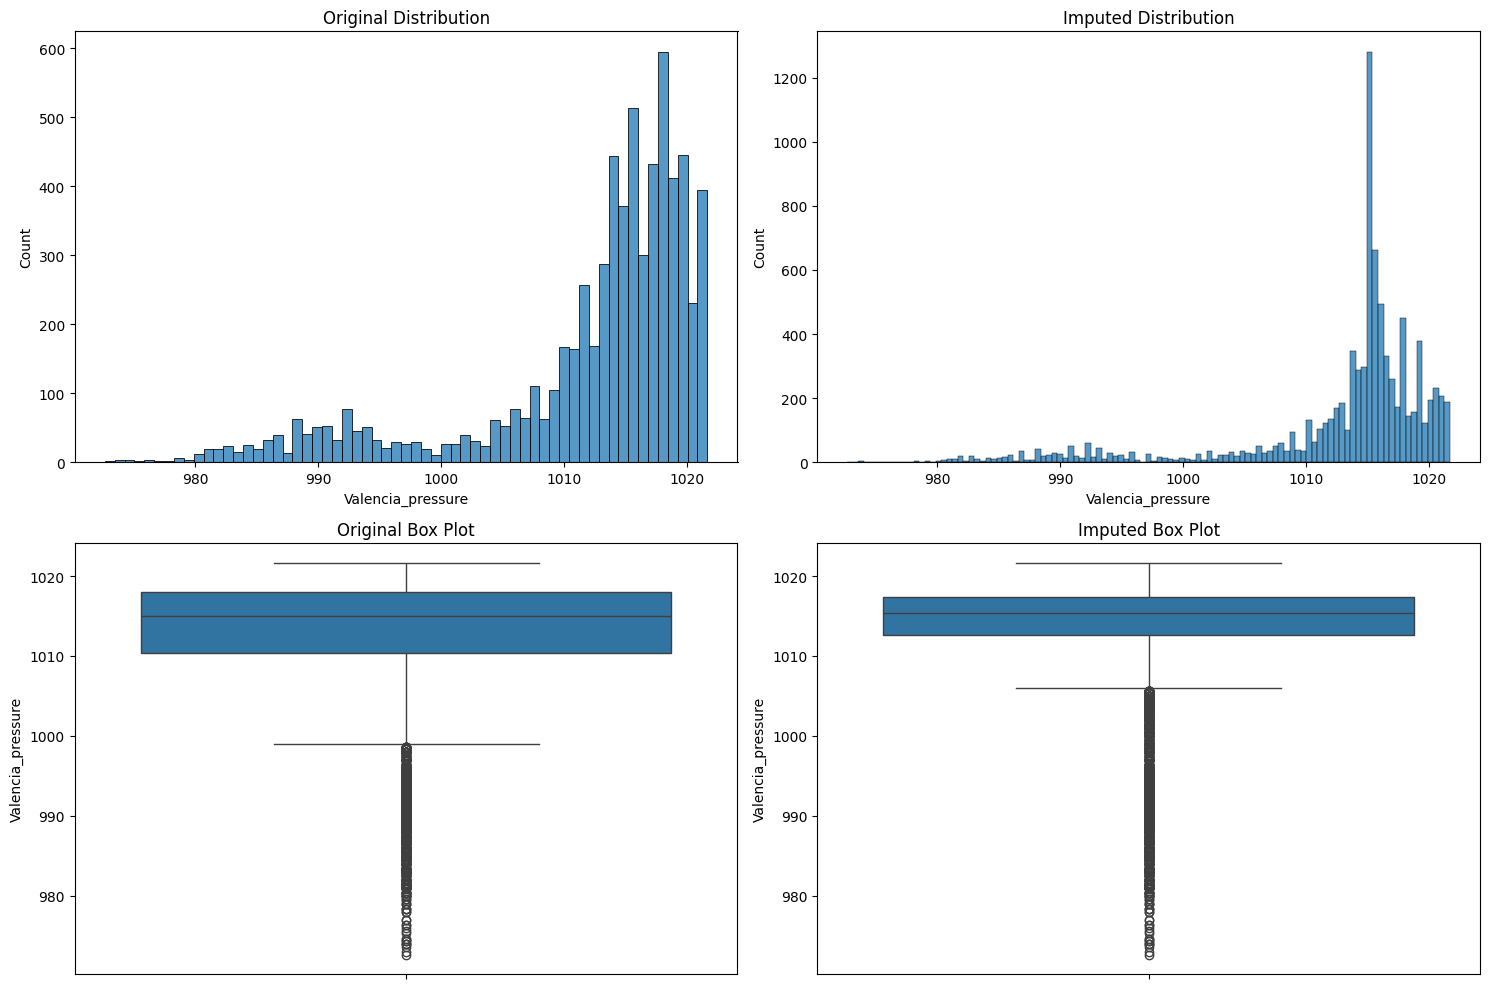


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 2068.00
missing_percentage: 23.59
mean: 1012.05
median: 1015.00
std: 9.51
min: 972.67
max: 1021.67

Imputed Data:
missing_count: 0.00
missing_percentage: 0.00
mean: 1012.81
median: 1015.33
std: 8.43
min: 972.67
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 0.76 (+0.08%)
median: 0.33 (+0.03%)
std: -1.08 (-11.37%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


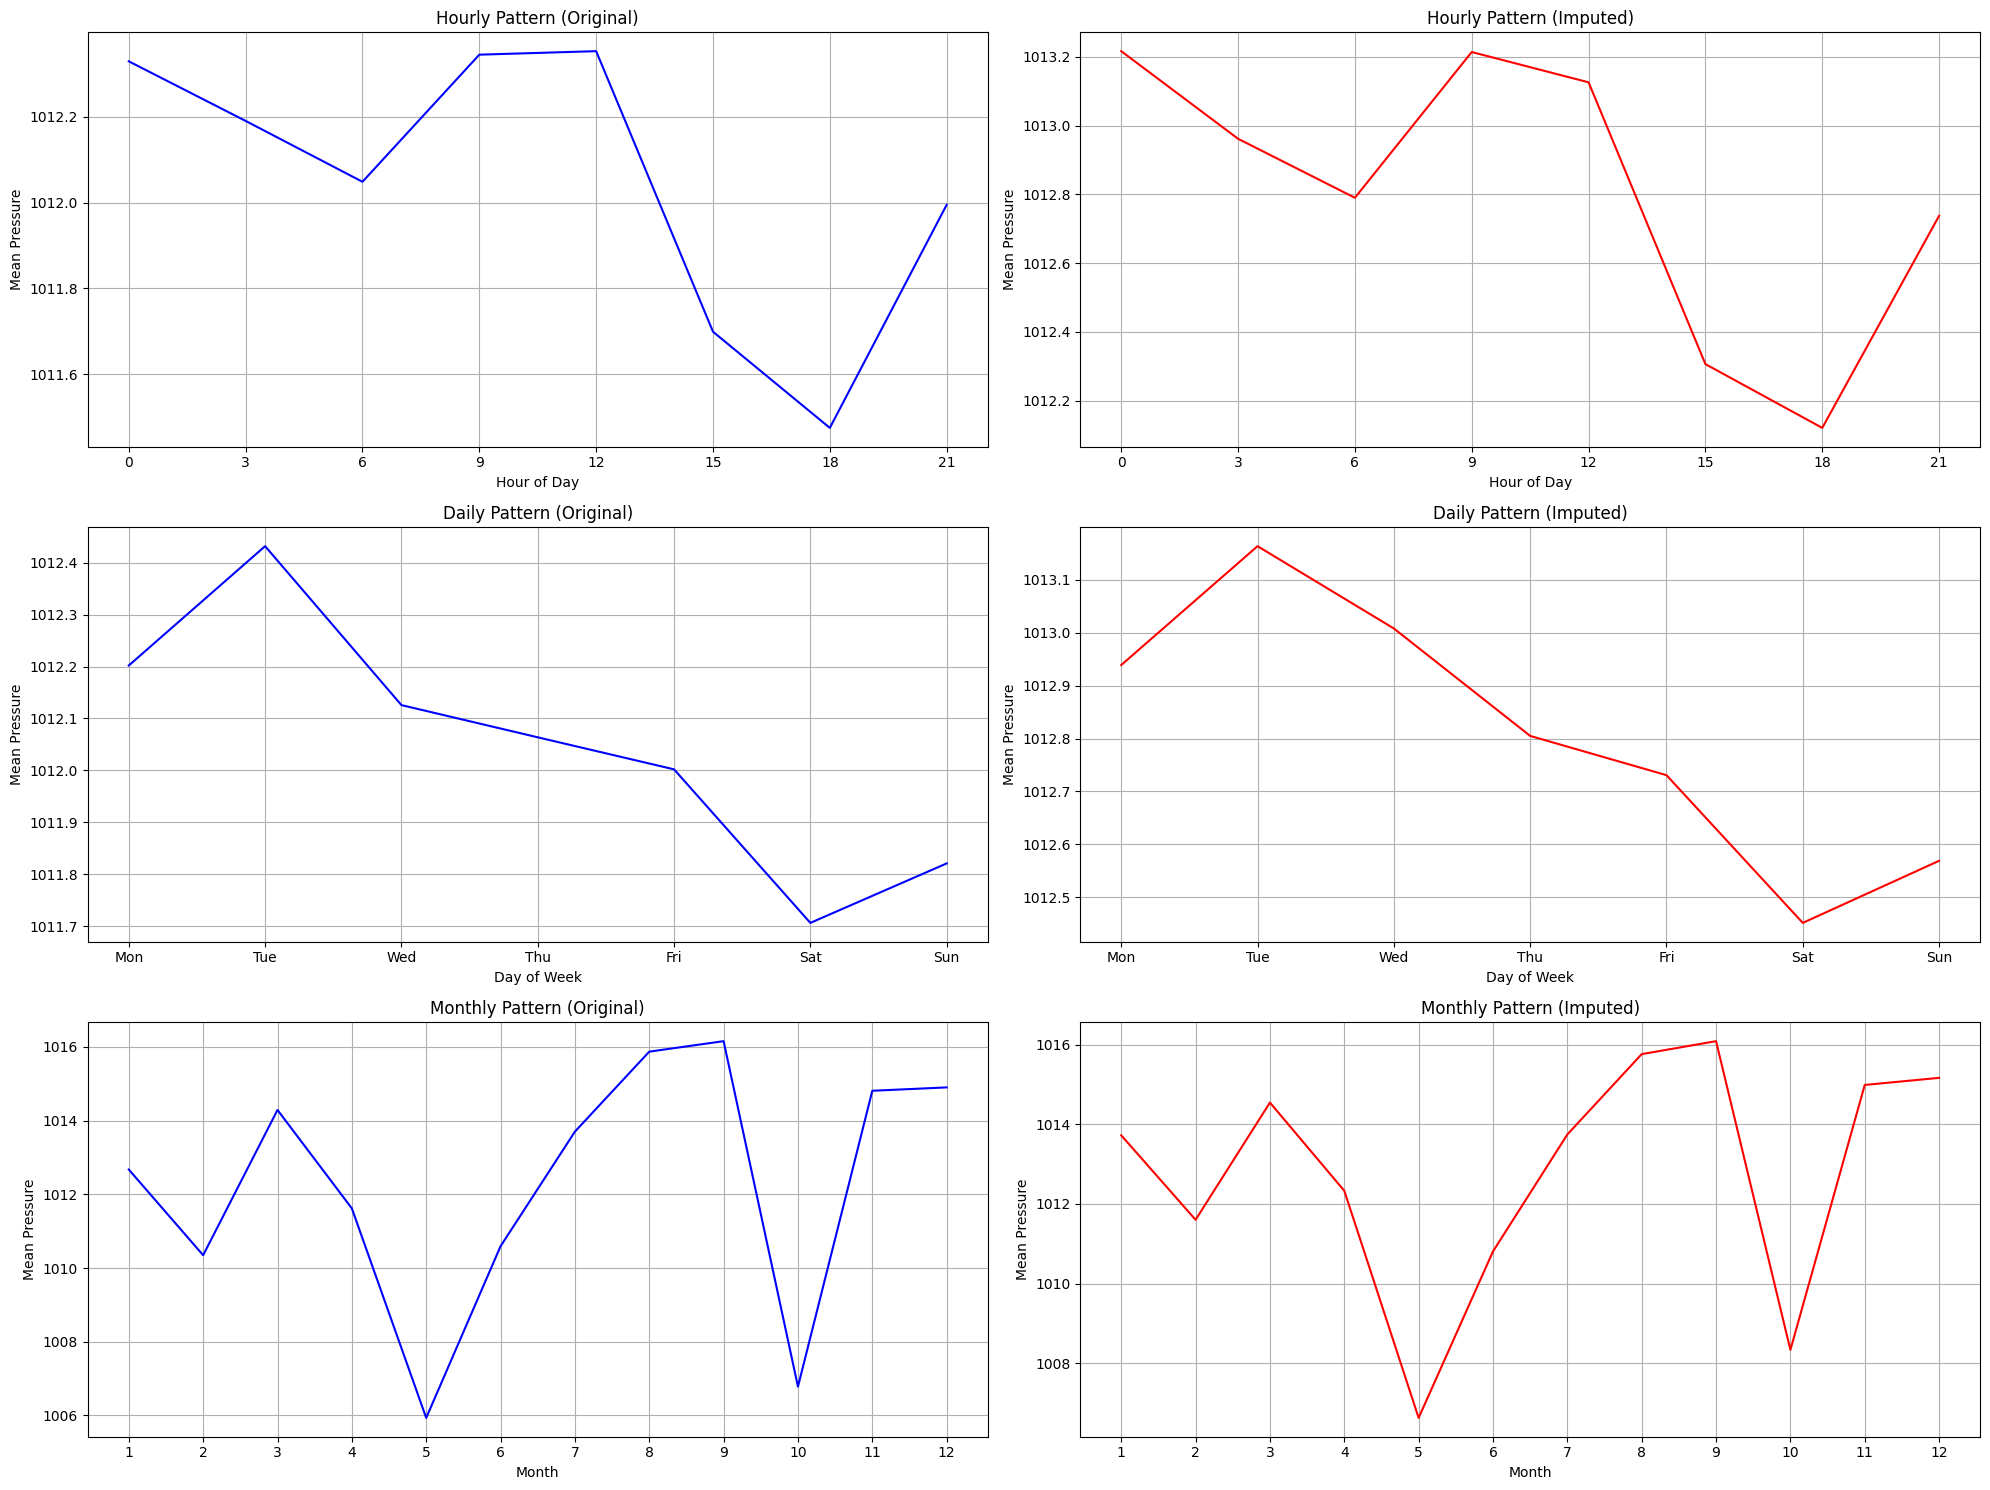


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 0.75
Maximum difference: 0.89

Daily Pattern Differences:
Mean absolute difference: 0.76
Maximum difference: 0.88

Monthly Pattern Differences:
Mean absolute difference: 0.53
Maximum difference: 1.55


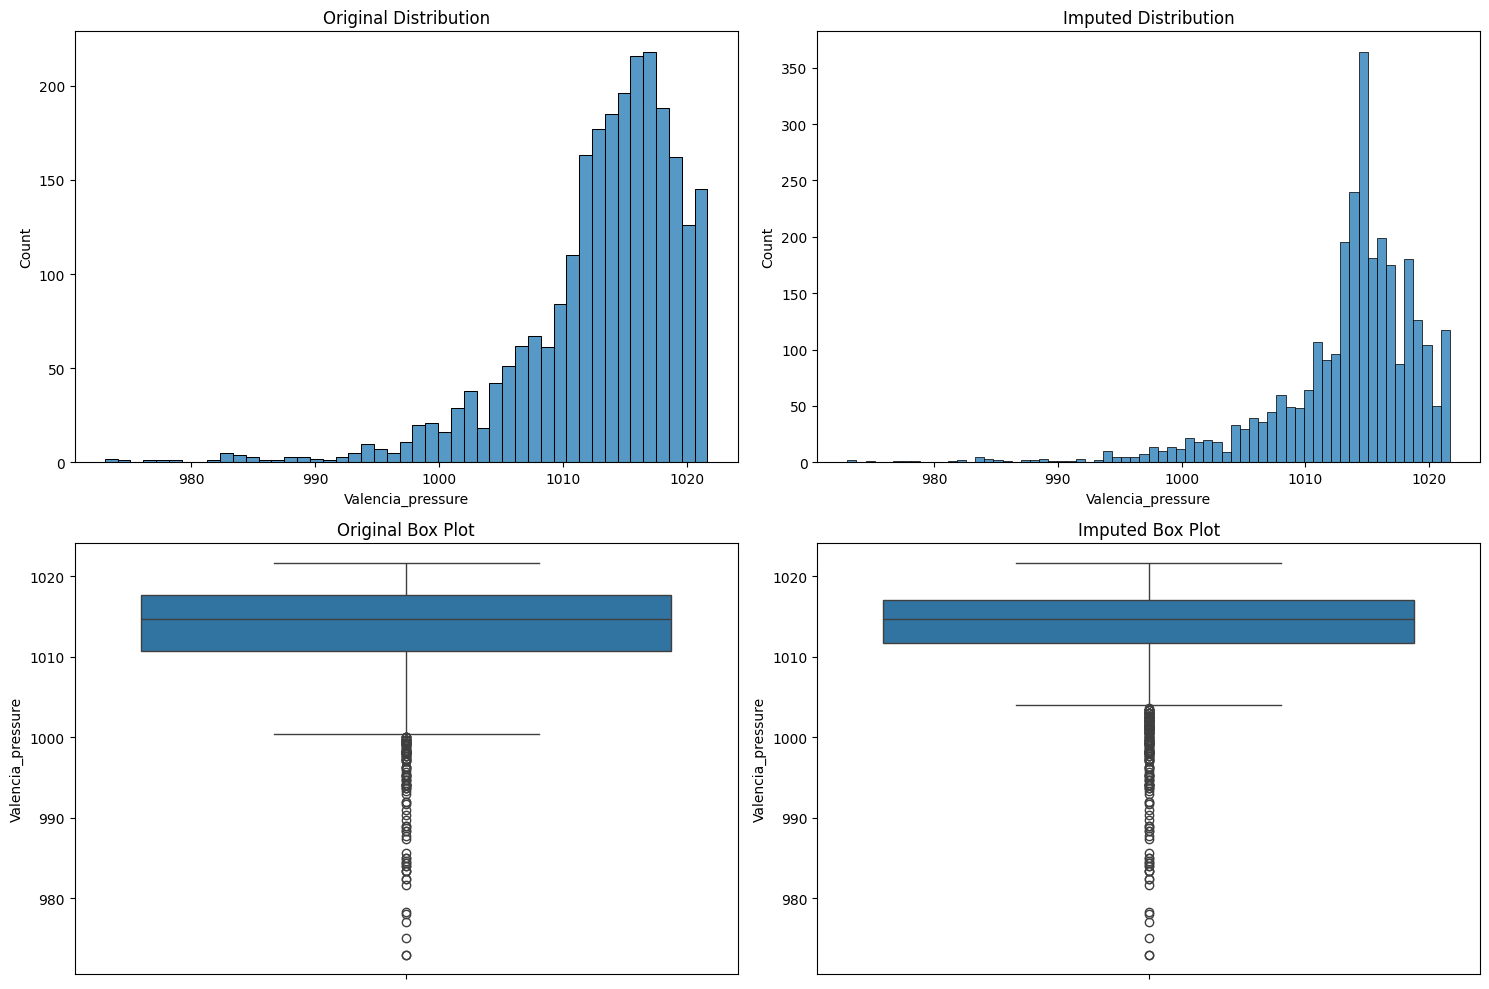


Imputation Statistics:
--------------------------------------------------

Original Data:
missing_count: 454.00
missing_percentage: 15.55
mean: 1013.15
median: 1014.67
std: 6.53
min: 973.00
max: 1021.67

Imputed Data:
missing_count: 0.00
missing_percentage: 0.00
mean: 1013.37
median: 1014.67
std: 6.03
min: 973.00
max: 1021.67

Changes after imputation:
--------------------------------------------------
mean: 0.22 (+0.02%)
median: 0.00 (+0.00%)
std: -0.50 (-7.63%)
min: 0.00 (+0.00%)
max: 0.00 (+0.00%)

Analyzing Temporal Patterns...


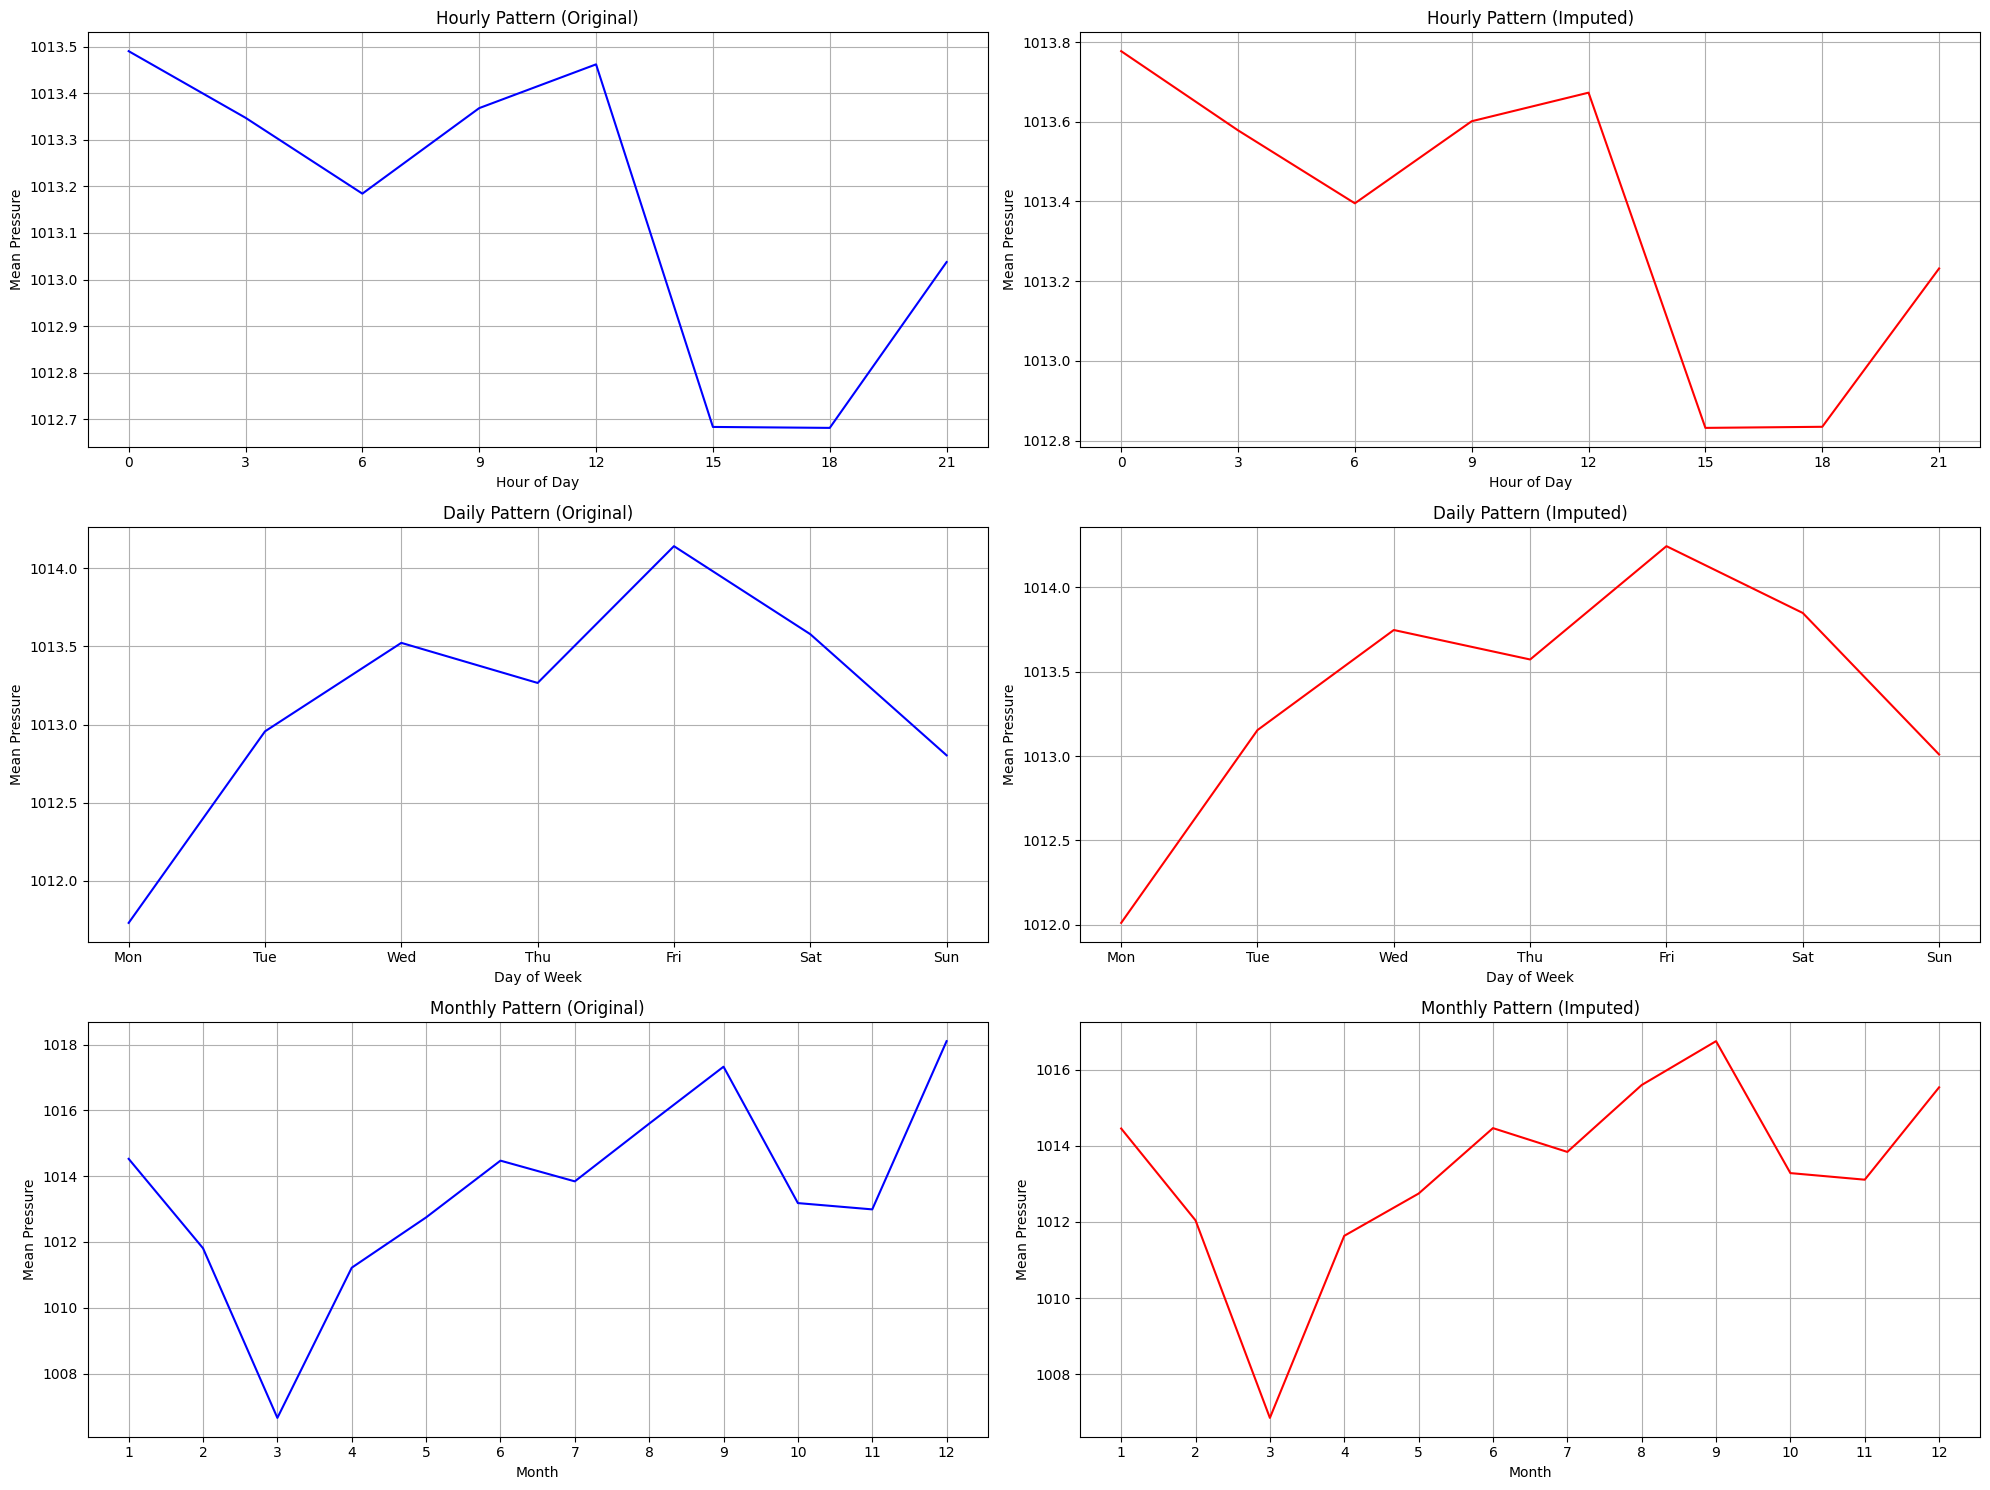


Temporal Pattern Statistics:
--------------------------------------------------

Hourly Pattern Differences:
Mean absolute difference: 0.21
Maximum difference: 0.29

Daily Pattern Differences:
Mean absolute difference: 0.23
Maximum difference: 0.31

Monthly Pattern Differences:
Mean absolute difference: 0.36
Maximum difference: 2.56


In [78]:

for imputer in [InterpolationImputer(max_gap=24), TimeAwareKNNImputer(n_neighbors=5), SimplifiedPatternImputer()]:
    print(f"Training Stats with {imputer.__class__.__name__}")
    original_df, imputed_df, stats = analyze_valencia_pressure_imputation_with_temporal(copy_train_df, imputer)   
    
    original_df, imputed_df, stats = analyze_valencia_pressure_imputation_with_temporal(copy_test_df, imputer)